# Agricultural Productivity

This first notebook extracts vegetation index for static crop areas, defines a baseline, and examines how the current season relate to the baseline.

## Setup

In [3]:
# import ee
# ee.Authenticate()

In [146]:
import sys, os
from os.path import join, expanduser, basename
import time
sys.path.append(join(expanduser('~'), 'Repos', 'GEE_Zonal', 'src'))

# Data
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import shapely
import geojson
import numpy as np

## Earth Engine APIs
import ee
from gee_zonal import Catalog, ZonalStats, authenticateGoogleDrive, gpd_to_gee
from geemap.conversion import *
from geemap import Map, colormaps

import xarray as xr
import rioxarray
from tqdm.notebook import tqdm
from dask.distributed import Client, LocalCluster
import requests

import matplotlib.pyplot as plt
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format   

from scipy.signal import savgol_filter, wiener
from scipy.stats import zscore
from statsmodels.tsa.seasonal import STL as stl

sys.path.append(join(expanduser('~'), 'Repos', 'phenolopy', 'scripts'))
import phenolopy
import dask

sys.path.append(join(expanduser('~'), 'Repos', 'GOSTrocks', 'src'))
import GOSTrocks.rasterMisc as rMisc

from rasterstats import zonal_stats
import rasterio as rio

## Data

### Modis

In [5]:
start_period = ee.Date('2001-01-01')
end_period = ee.Date('2024-01-01')

terra = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .select(['EVI','SummaryQA','DetailedQA'])   \
    .filterDate(start_period, end_period)
aqua = ee.ImageCollection('MODIS/061/MYD13Q1')  \
    .select(['EVI','SummaryQA','DetailedQA'])   \
    .filterDate(start_period, end_period)

modis = terra.select('EVI').merge(aqua.select('EVI'))
modis = modis.sort("system:time_start")

def bitwiseExtract(value, fromBit, toBit=None):
  if (toBit == None):
    toBit = fromBit
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return value.rightShift(fromBit).bitwiseAnd(mask)

# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
  sqa = image.select('SummaryQA')
  dqa = image.select('DetailedQA')
  viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
  viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
  # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
  viSnowIceFlagsD = bitwiseExtract(dqa, 14)
  viShadowFlagsD = bitwiseExtract(dqa, 15)
  # Good data, use with confidence
  mask = viQualityFlagsS.eq(0)  \
    .And(viQualityFlagsD.eq(0)) \
    .And(viQualityFlagsS.eq(1)) \
    .And(viQualityFlagsD.eq(1)) \
    .And(viSnowIceFlagsD).eq(0); 
    # .And(viShadowFlagsD).eq(0); # No shadow
  return image.updateMask(mask)

mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select('EVI').merge(myd13q1_QC.select('EVI'))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    '0':'ocean',
    '1':'non_crop',
    '2':'crop_irrigated',
    '3':'crop_rainfed',
}
# lgrip30 = ee.ImageCollection("projects/sat-io/open-datasets/GFSAD/LGRIP30").mosaic() #.clip(geoj)
# crop_data = lgrip30.select('b1').gt(1).rename('crop')

dea = ee.ImageCollection("projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/mask").mosaic() # filtered
crop_data = dea.select('b1').gt(0).rename('crop')

### Admin

In [273]:
iso3 = 'NER'
country = 'Niger'
release_type = 'gbOpen'

adm = 'ADM0'
geo_url = f'https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/'
res = requests.get(geo_url).json()
print("Reading "+ res['gjDownloadURL'])
adm0_ner = gpd.read_file(res['gjDownloadURL'])

adm = 'ADM1'
geo_url = f'https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/'
res = requests.get(geo_url).json()
print("Reading "+ res['gjDownloadURL'])
adm1_ner = gpd.read_file(res['gjDownloadURL'])

adm = 'ADM2'
geo_url = f'https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/'
res = requests.get(geo_url).json()
print("Reading "+ res['gjDownloadURL'])
adm2_ner = gpd.read_file(res['gjDownloadURL'])

# adm1_ner.to_file('adm1_ner.geojson', driver='GeoJSON')
# adm1_ner = gpd.read_file('adm1_ner.geojson')
# adm2_ner.to_file('adm2_ner.geojson', driver='GeoJSON')
# adm2_ner = gpd.read_file('adm2_ner.geojson')

Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/NER/ADM0/geoBoundaries-NER-ADM0.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/NER/ADM1/geoBoundaries-NER-ADM1.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/NER/ADM2/geoBoundaries-NER-ADM2.geojson


In [4]:
aoi = gpd_to_gee(adm0_ner)

In [5]:
scale_factor=0.0001
# apply cropland mask to imageCollection
# def cropmask(img):
#   return img.clip(aoi) #.multiply(scale_factor) # unmask(-1)
def cropmask(img):
  return img.updateMask(crop_data).clip(aoi) #.multiply(scale_factor) # unmask(-1)
mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)

### Map

In [8]:
crop_data_raw = lgrip30.select('b1').rename('crop').clip(aoi)
crop_data_viz = crop_data_raw.mask(crop_data_raw.gt(1))

In [9]:
# one = adm1_ner_sel.iloc[[0]]
one = adm0_ner.iloc[[0]]
centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]

viVis2 = {
  'min': 0.2,
  'max': 0.6,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}
pal = colormaps.get_palette('Greens', 10) # Greens BrBG
crop_vis = {
    'min': 2,
    'max': 3,
    'palette': ['#cc0000', '#529400'],
    'opacity': 0.75
}
ndvi_vis = {
    'min': 0.2,
    'max': 0.6,
    'palette': pal
}
adm_vis = {
    'color': '000000',
    'width': 1,
    'opacity': 0.5
}

img = mxd13q1.filterDate('2023-08-01', '2023-09-01').select('EVI').first().multiply(scale_factor)

/tmp/ipykernel_2198204/3884362397.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [10]:
from geemap.foliumap import Map

In [11]:
# initialize our map
m = Map(center=[centy, centx], zoom=8) # basemap='Esri.WorldImagery'
m.add_basemap('Esri.WorldImagery')
m.addLayer(crop_data_viz, crop_vis, 'Crop Mask (LGRIP30)') # Green is Rainfed, Red is Irrigated
m.addLayer(aoi, adm_vis, 'geoBoundaries')
m.addLayer(img, ndvi_vis, 'VI')
# m.add_data(labels, column='land_use_t', layer_name='Crop Reference USGS')
m.addLayerControl()
m

### Pull Xarray Data

In [6]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [6]:
utm = 'EPSG:32632' # 'EPSG:4326' 'SR-ORG:6974' 'EPSG:23847'

In [ ]:
ds_all = []
scale_factor=0.0001
years = range(2001, 2024)
months = range(1, 13)
for year in tqdm(years):
    for month in tqdm(months):
        modis_sel = mxd13q1.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month'))
        # modis_sel = mxd13q1.filterDate(f'{year}-{month}-01', f'{year}-{month+1}-01')
        ds = xr.open_dataset(
            modis_sel,
            engine = 'ee',
            geometry = aoi.geometry(),
            crs = utm,
            scale = 250,
            )
        ds = ds*scale_factor
        ds = ds.compute()
        ds_all.append(ds)
    # print(f"Finished {year}")

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
ds = xr.concat(ds_all, dim='time')

In [14]:
ds = ds.isel(Y=slice(None, None, -1))

### Save Data

In [7]:
data_dir = join(expanduser('~'), 'data', 'niger')
# data_dir = join(expanduser('~'), 'tmp', 'niger')
os.path.exists(data_dir)

True

In [ ]:
ds.to_netcdf(join(data_dir, "modis_crop_dea.nc"))

### Load Data

In [18]:
ds = xr.open_dataset(join(data_dir, "modis_crop_dea.nc")) # maradi
# ds = ds.isel(time=range(0,23))

In [20]:
# ds

### Dask Prep

In [8]:
import multiprocessing
multiprocessing.cpu_count()

256

In [9]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
# cluster = LocalCluster()
# explicitly connect to the cluster we just created
# client = Client(cluster)
# client

# Dask Prep
workers = 24 # 50
cluster = LocalCluster(n_workers=workers)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 264,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33099,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 264
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33161,Total threads: 11
Dashboard: http://127.0.0.1:33463/status,Memory: 41.98 GiB
Nanny: tcp://127.0.0.1:33105,


In [159]:
client.close()
client.shutdown()

### Process by year

In [ ]:
ds_all = []
years = range(2004, 2024) # 2001 2024
for year in tqdm(years):
    ds_sel = ds.sel(time=ds.time.dt.year==year)
    dask_chunks={"time": -1, "X": 500, "Y": 500}
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = ds_sel.rename_vars({'EVI':'veg_index'})
    ds_sel = phenolopy.remove_outliers(ds=ds_sel, method='median', user_factor=2, z_pval=0.05)
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = phenolopy.interpolate(ds=ds_sel, method='interpolate_na')
    ds_sel = phenolopy.smooth(ds=ds_sel, method='savitsky', window_length=3, polyorder=1)
    ds_sel = ds_sel.compute()
    ds_all.append(ds_sel)
    print(f"Finished {year}")

  0%|          | 0/20 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/tornado/ioloop.py:937: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  val = self.callba

Finished 2004
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del sel

Finished 2005
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/tornado/ioloop.py:937: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  val = self.callba

Finished 2006
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/tornado/ioloop.py:937: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  val = self.callback()


Finished 2007
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]


Finished 2008
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]


Finished 2009
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Finished 2010
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]


Finished 2011
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Finished 2012
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/tornado/ioloop.py:937: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  val = self.callback()
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/xarray/backends/lru_cache.py:71: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  del self._cache[key]


Finished 2013
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


In [24]:
len(ds_all)

20

In [25]:
ds2 = xr.concat(ds_all, dim='time')

In [26]:
# Flip the data along the y-axis
# ds2 = ds2.isel(Y=slice(None, None, -1))
ds_geo = ds2.copy()
ds_geo.rio.write_crs(utm, inplace=True)
ds_geo = ds_geo.transpose('time', 'Y', 'X')
ds_geo = ds_geo.rename({'Y': "y", 'X': "x"})
ds_geo.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
ds_geo.to_zarr(join(data_dir, "modis_crop_dea_processed.zarr"))

### Load Zarr

In [10]:
data_dir = join(expanduser('~'), 'data', 'niger')
# data_dir = join(expanduser('~'), 'tmp', 'niger')
os.path.exists(data_dir)

True

In [11]:
ds_geo = xr.open_zarr(join(data_dir, "modis_crop_dea_processed.zarr"))
ds_geo

<xarray.Dataset> Size: 130GB
Dimensions:      (time: 920, y: 5242, x: 6727)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 7kB 2004-01-01 2004-01-09 ... 2023-12-27
  * x            (x) float64 54kB -4.661e+05 -4.658e+05 ... 1.215e+06 1.215e+06
  * y            (y) float64 42kB 2.618e+06 2.618e+06 ... 1.308e+06 1.308e+06
Data variables:
    veg_index    (time, y, x) float32 130GB dask.array<chunksize=(29, 164, 421), meta=np.ndarray>

## Anomalies per Pixel

In [12]:
# add a new date format to the dataset
# ds_ref['md'] = ds_ref.time.dt.strftime('%m-%d')

In [13]:
# ds_geo

In [14]:
ds_monthly = ds_geo.resample(time='1M').mean()

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


In [15]:
# ds_monthly['m'] = ds_monthly.time.dt.strftime('%m')

In [16]:
ds_monthly

<xarray.Dataset> Size: 34GB
Dimensions:      (time: 240, y: 5242, x: 6727)
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 54kB -4.661e+05 -4.658e+05 ... 1.215e+06 1.215e+06
  * y            (y) float64 42kB 2.618e+06 2.618e+06 ... 1.308e+06 1.308e+06
  * time         (time) datetime64[ns] 2kB 2004-01-31 2004-02-29 ... 2023-12-31
Data variables:
    veg_index    (time, y, x) float32 34GB dask.array<chunksize=(1, 164, 421), meta=np.ndarray>

In [17]:
start_reference = "2004-01-01"
end_reference = "2022-01-01"

### Percentage Change

In [109]:
# ds_ref = ds_monthly.sel(time=slice(None, end_reference)) # ds_geo
# ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2023)
# ds_2023_09 = ds_filt.sel(time=ds_filt.time.dt.month==9).isel(time=0)
# ds_ref_09 = ds_ref.sel(time=ds_ref.time.dt.month==9).mean(dim='time')
# ds_diff = ds_2023_09 - ds_ref_09
# ds_pct_ch = (ds_diff / ds_ref_09)

In [119]:
# ds_pct_ch = ds_pct_ch.compute()

In [23]:
# ds_pct_ch['veg_index'].rio.write_nodata(np.nan, inplace=True)

In [140]:
# ds_pct_ch['veg_index'].rio.to_raster(join(data_dir, 'pct_ch_2023_09.tif'))

### Z Score

In [18]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference)) # ds_geo
ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2023)

ds_2023_09 = ds_filt.sel(time=ds_filt.time.dt.month==9).isel(time=0)
ds_ref_09_mean = ds_ref.sel(time=ds_ref.time.dt.month==9).mean(dim='time')
ds_ref_09_sdt = ds_ref.sel(time=ds_ref.time.dt.month==9).std(dim='time')

ds_diff = ds_2023_09 - ds_ref_09_mean
ds_zscore = (ds_diff / ds_ref_09_sdt)

In [19]:
ds_zscore = ds_zscore.compute()

/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_com

In [20]:
ds_zscore['veg_index'].rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'veg_index' (y: 5242, x: 6727)> Size: 141MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 54kB -4.661e+05 -4.658e+05 ... 1.215e+06 1.215e+06
  * y            (y) float64 42kB 2.618e+06 2.618e+06 ... 1.308e+06 1.308e+06
    time         datetime64[ns] 8B 2023-09-30
Attributes:
    _FillValue:  nan

In [45]:
ds_zscore['veg_index'].rio.to_raster(join(data_dir, 'zcore_dea_2023_09.tif'))

### Try Leafmap

In [166]:
# import leafmap
import leafmap.foliumap as leafmap

import rasterio
import rioxarray
import xarray as xr

In [157]:
url1 = "https://open.gishub.org/data/raster/landsat.tif"
url2 = "https://open.gishub.org/data/raster/srtm90.tif"
satellite = leafmap.download_file(url1, "landsat.tif", overwrite=True)
dem = leafmap.download_file(url2, "srtm90.tif")

Downloading...
From: https://open.gishub.org/data/raster/landsat.tif
To: /home/jupyter-wb514197/landsat.tif
100%|██████████| 10.1M/10.1M [00:00<00:00, 76.2MB/s]
Downloading...
From: https://open.gishub.org/data/raster/srtm90.tif
To: /home/jupyter-wb514197/srtm90.tif
100%|██████████| 16.6M/16.6M [00:00<00:00, 88.6MB/s]


In [159]:
dataset = rasterio.open(satellite)
nir = dataset.read(4).astype(float)
red = dataset.read(1).astype(float)
ndvi = (nir - red) / (nir + red)

In [161]:
ndvi_image = leafmap.array_to_image(ndvi, source=satellite)

In [163]:
ndvi_image.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2127, 'height': 1564, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(180.0, 0.0, -13442580.0,
       0.0, -180.0, 4670100.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [169]:
# import localtileserver
# print(localtileserver.Report())

In [170]:
# m = leafmap.Map()
# m.add_raster(satellite, indexes=[4, 1, 2], vmin=0, vmax=120, layer_name="Landsat 7")
# m.add_raster(ndvi_image, colormap="Greens", layer_name="NDVI")
# m

In [150]:
da = ds_pct_ch['veg_index']

In [155]:
# m = leafmap.Map()
# m.add_raster(da, colormap="BrBG", layer_name="VEG Index")
# # m.add_raster(dem, colormap="terrain", layer_name="DEM")
# # m.add_raster(masked_array, colormap="coolwarm", layer_name="Classified DEM")
# m

In [142]:
ds_pct_ch['veg_index'].max()

<xarray.DataArray 'veg_index' ()> Size: 4B
array(2383.3328, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
    time         datetime64[ns] 8B 2023-09-30

In [143]:
ds_pct_ch['veg_index'].min()

<xarray.DataArray 'veg_index' ()> Size: 4B
array(-119.153114, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
    time         datetime64[ns] 8B 2023-09-30

## Summary of Anomalies

In [21]:
# data = ds_pct_ch['veg_index'].values
data = ds_zscore['veg_index'].values
data = data[~np.isnan(data)]

In [22]:
data = data[~np.isnan(data)]

In [132]:
# bins = np.linspace(-0.5, 0.5, 21)
# bins = range(-5, 5, 1)
# bins = np.linspace(-3, 3, 13)
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, -0.5]', '(0.5, 1]', '(1, 2]', '> 2']
bins

[-20, -2, -1, -0.5, 0.5, 1, 2, 20]

### Numpy Way

In [48]:
vals, bins = np.histogram(data, bins=bins)
df = pd.DataFrame({'vals': vals, 'bins': bins[:-1]})

<Axes: xlabel='bins'>

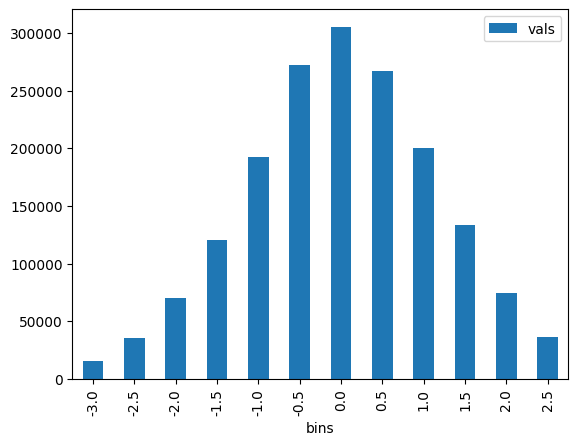

In [69]:
fig, ax = plt.subplots()
df.plot(kind='bar', x='bins', y='vals', ax=ax)

### Pandas way

In [153]:
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, -0.5]', '(0.5, 1]', '(1, 2]', '> 2']

df = pd.DataFrame(data, columns=['zscore'])
df.loc[:, 'zscore_bin'] = pd.cut(data, bins=bins, include_lowest=True, labels=bin_labels)
df2 = df['zscore_bin'].value_counts().sort_index()
df2 = pd.DataFrame(df2).reset_index()
df2.loc[:, 'pct'] = df2['count'] / df2['count'].sum()

In [154]:
font = "Liberation Sans"

In [155]:
df2

,zscore_bin,count,pct
0,< -2,58652,0.033413
1,"(-2, -1]",189878,0.108170
2,"(-1, -0.5]",192149,0.109463
3,"(-0.5, -0.5]",577571,0.329031
4,"(0.5, 1]",266766,0.151971
5,"(1, 2]",333452,0.189961
6,> 2,136904,0.077991


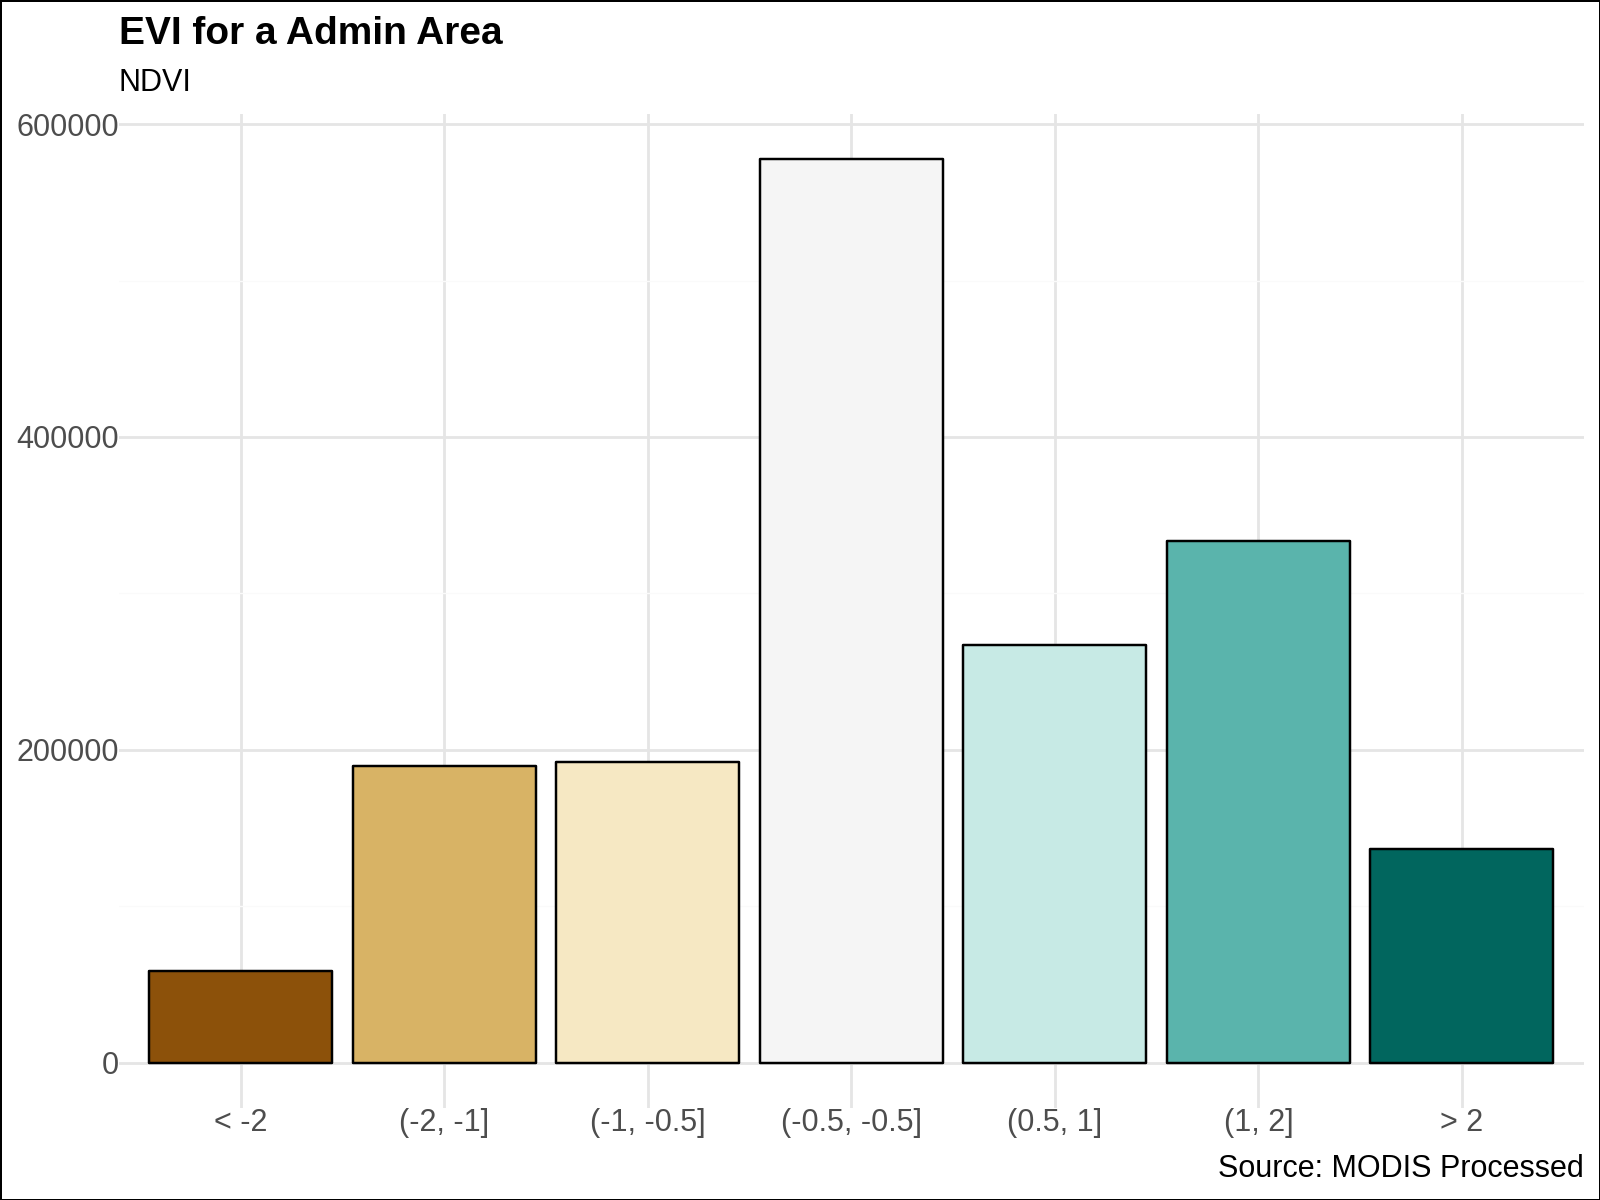

In [158]:
# fig, ax = plt.subplots()

(
ggplot(df2, aes(x="zscore_bin", y="count", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity', color='black') #  fill='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_fill_brewer(type='div', palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

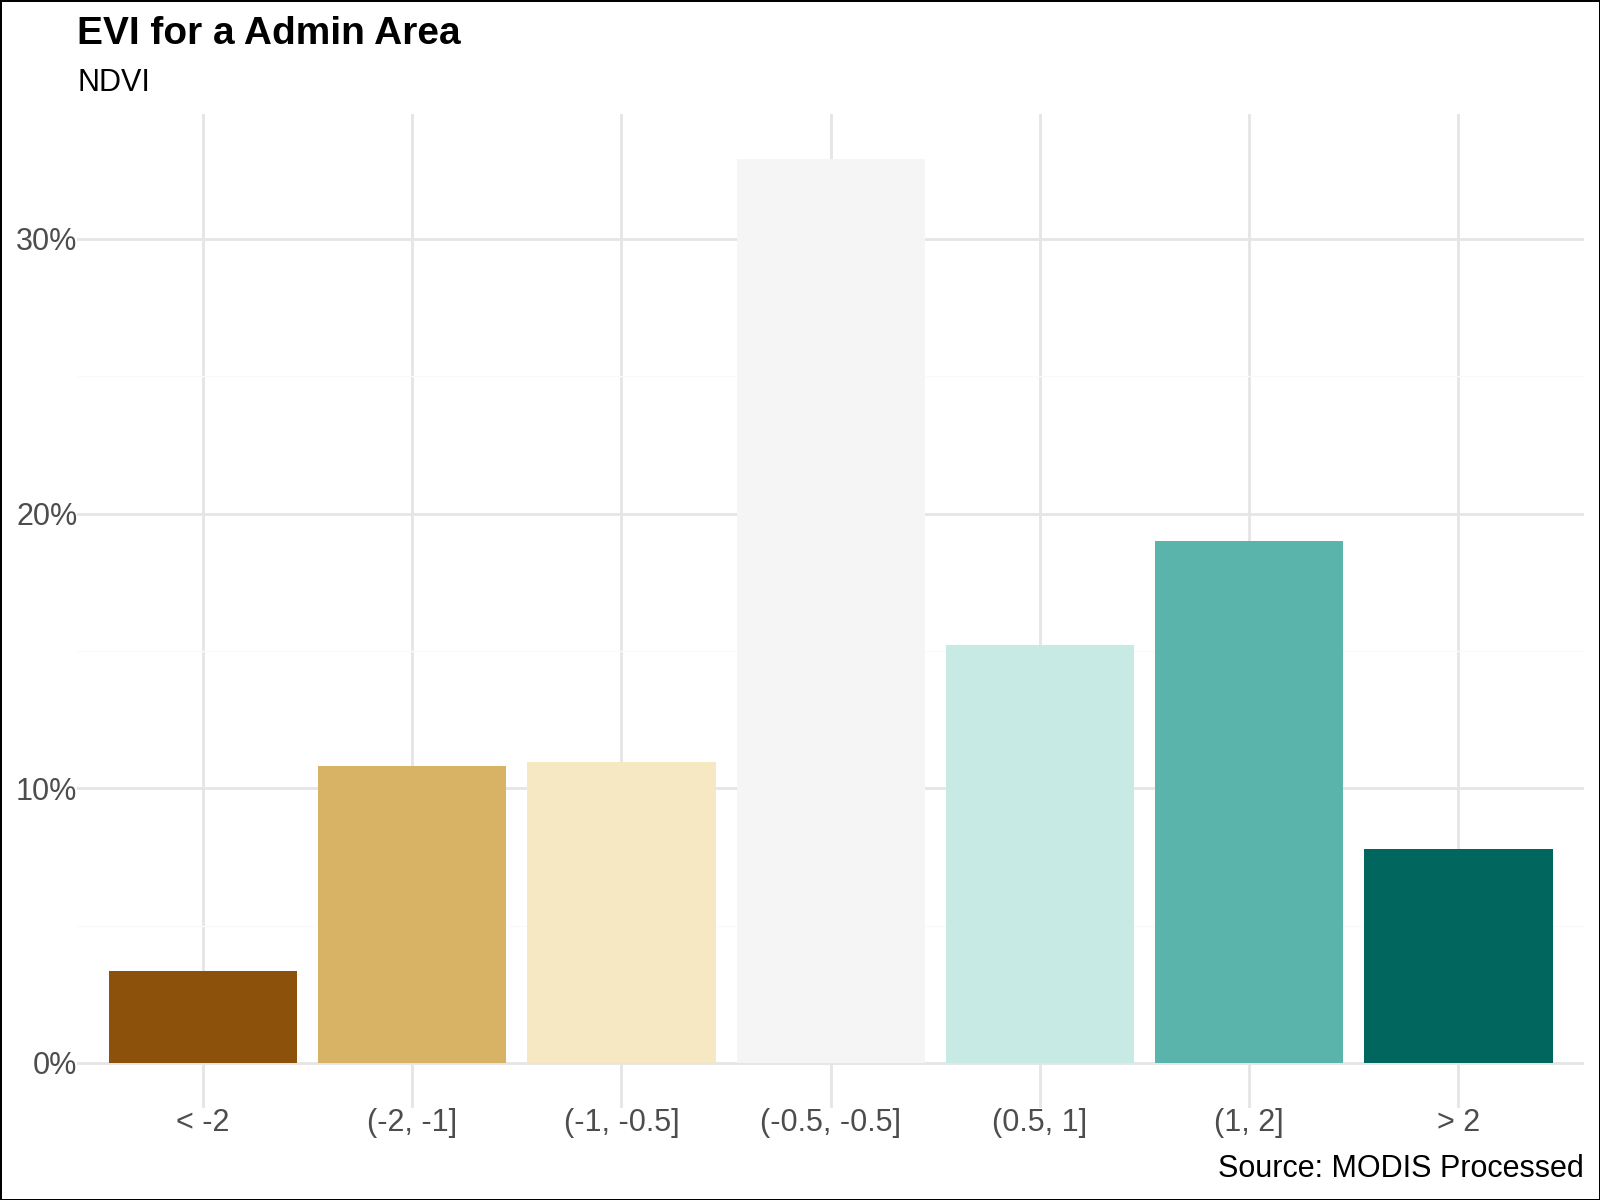

In [157]:
# fig, ax = plt.subplots()

(
ggplot(df2, aes(x="zscore_bin", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity') #  fill='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_fill_brewer(type='div', palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

### Less Bins

In [148]:
bins = [-20, -1, 1, 20]
bin_labels = ['< -1', '(-1, 1]', '> 1']

df = pd.DataFrame(data, columns=['zscore'])
df.loc[:, 'zscore_bin'] = pd.cut(data, bins=bins, include_lowest=True, labels=bin_labels)
df2 = df['zscore_bin'].value_counts().sort_index()
df2 = pd.DataFrame(df2).reset_index()
df2.loc[:, 'pct'] = df2['count'] / df2['count'].sum()

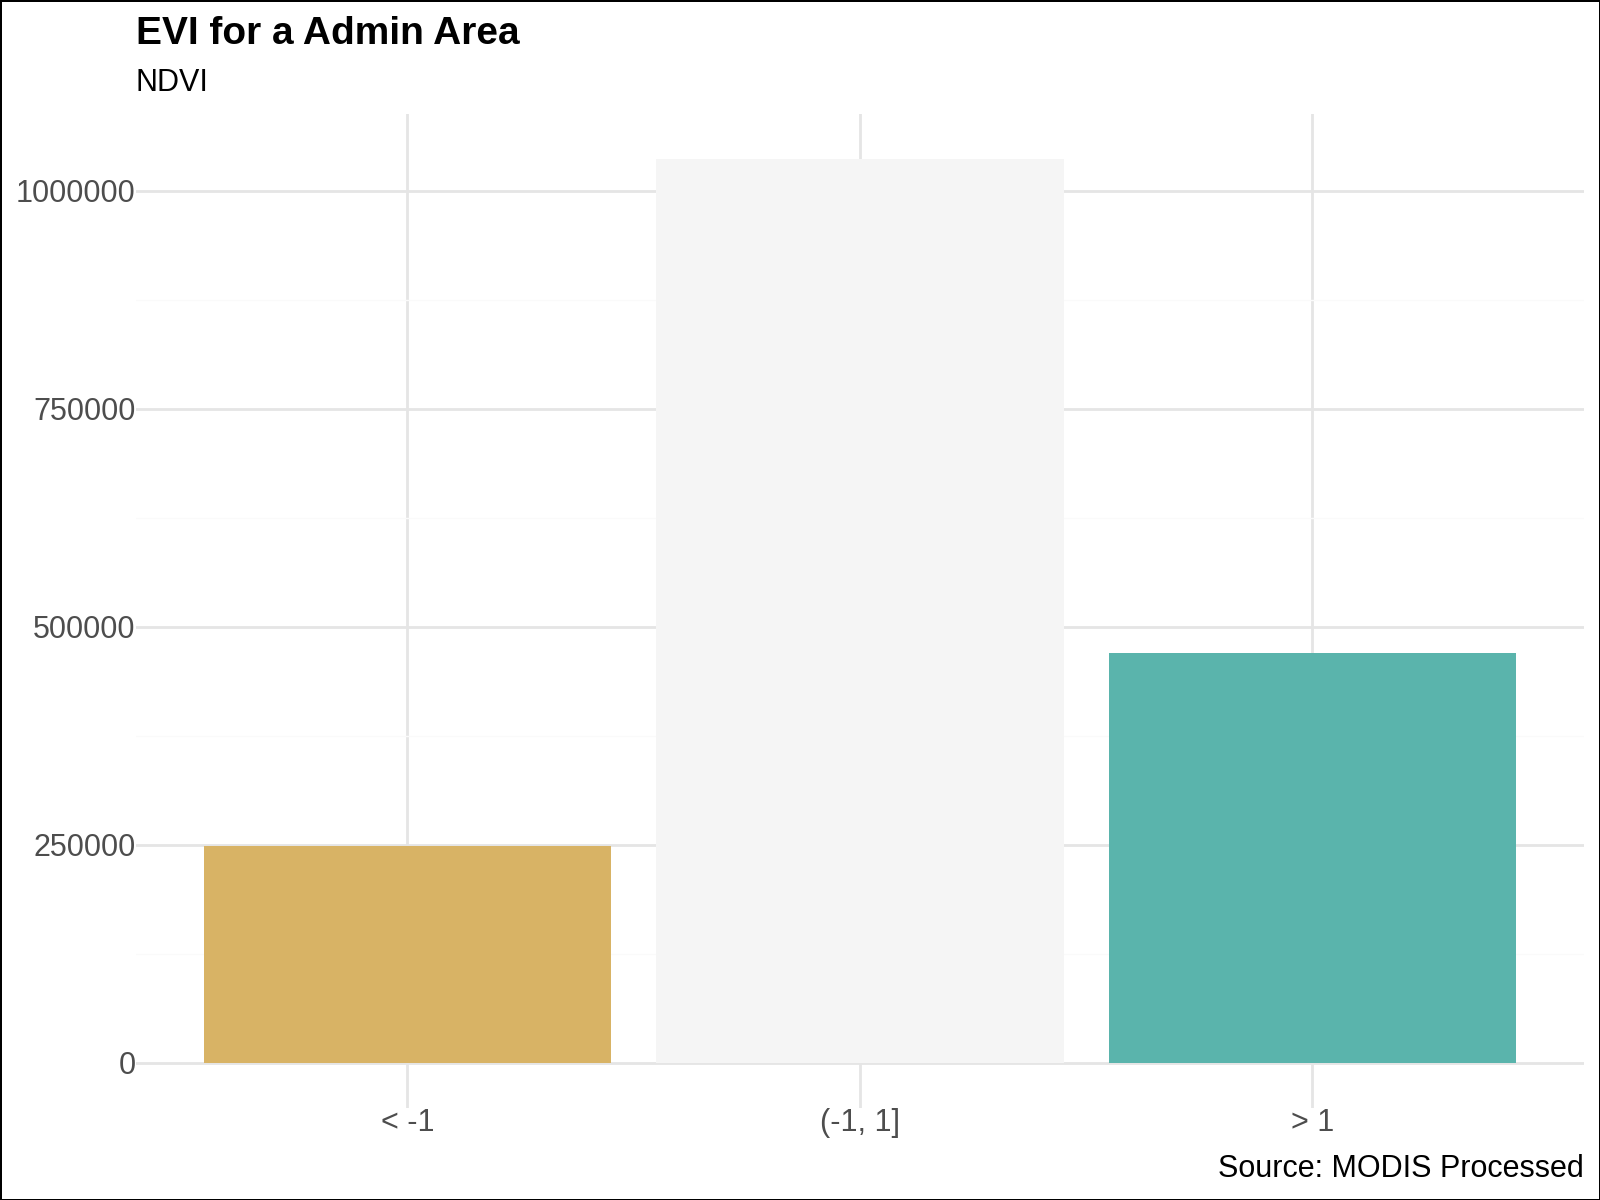

In [152]:
# fig, ax = plt.subplots()

(
ggplot(df2, aes(x="zscore_bin", y="count", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity') #  fill='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_fill_brewer(type='div', palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

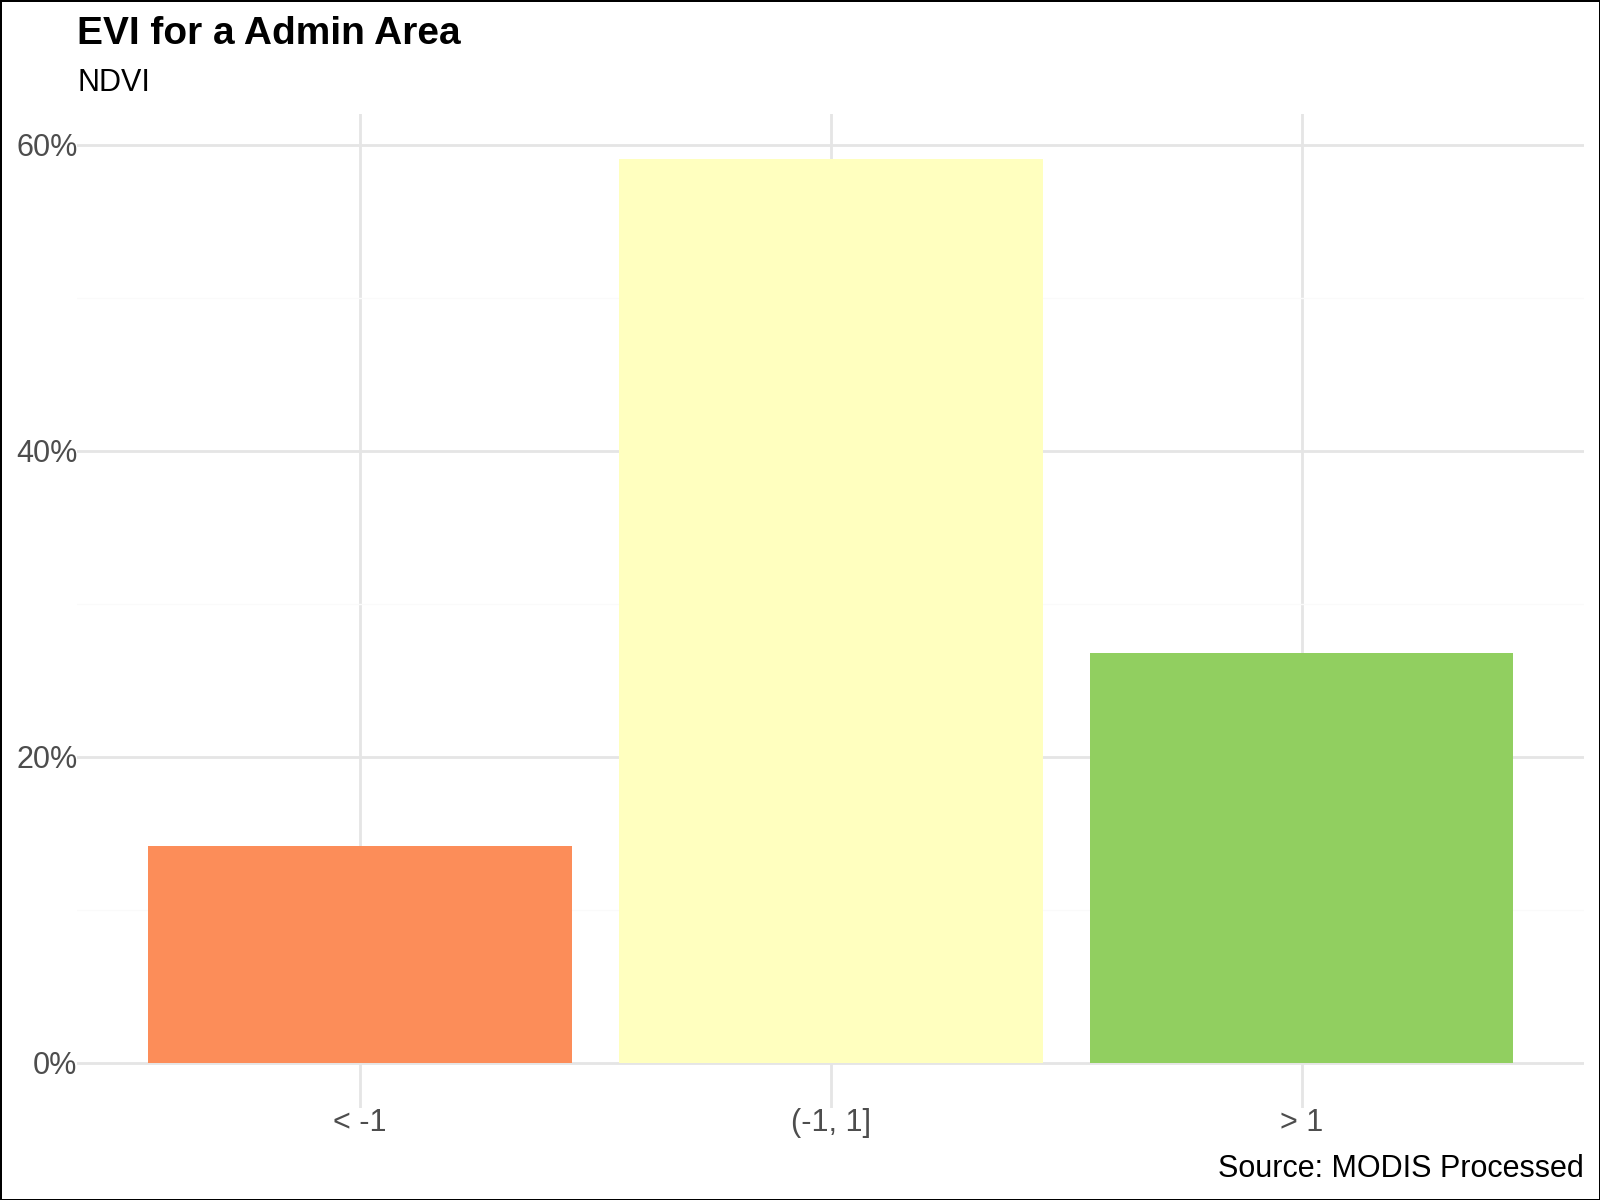

In [151]:
# fig, ax = plt.subplots()

(
ggplot(df2, aes(x="zscore_bin", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity') #  fill='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

### Example plots

<Axes: xlabel='zscore_bin'>

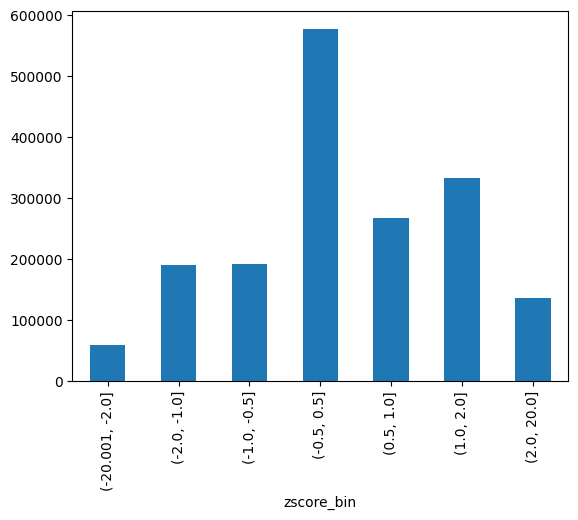

In [107]:
fig, ax = plt.subplots()
df['zscore_bin'].value_counts().sort_index().plot(kind='bar', ax=ax)

In [35]:
# df.reclassify(column='zscore', bins=bins)

In [32]:
# df.plot(kind='bar', bins=bins, alpha=0.5)

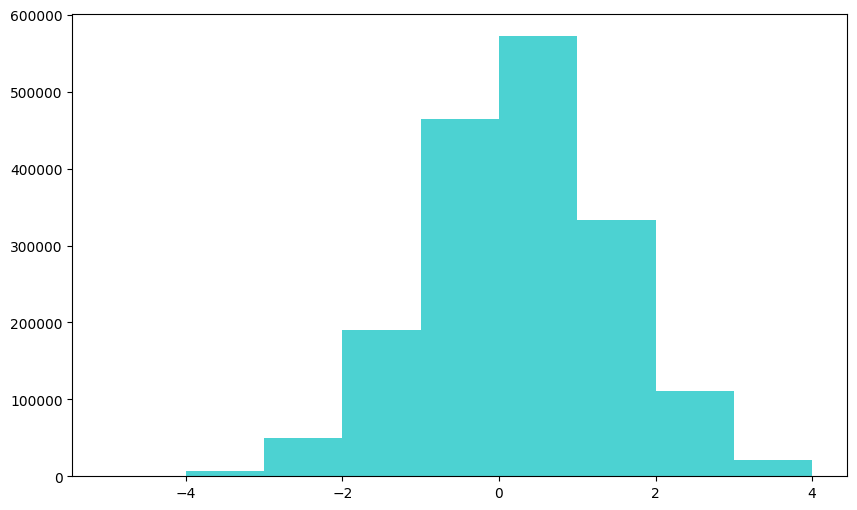

In [24]:
# # make a histogram plot of the data
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(data, bins=bins, color='c', alpha=0.7)
plt.show()

## Loop years

In [165]:
start_reference = "2004-01-01"
end_reference = "2019-01-01"

In [166]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference)) # ds_geo
ds_ref_09_mean = ds_ref.sel(time=ds_ref.time.dt.month==9).mean(dim='time')
ds_ref_09_sdt = ds_ref.sel(time=ds_ref.time.dt.month==9).std(dim='time')


# ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2023)
# ds_2023_09 = ds_filt.sel(time=ds_filt.time.dt.month==9).isel(time=0)
# ds_diff = ds_2023_09 - ds_ref_09_mean
# ds_zscore = (ds_diff / ds_ref_09_sdt)

In [169]:
res = []
years = range(2019, 2024)
for year in tqdm(years):
    print(f"Calc anomalies for {year}")
    ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==year)
    ds_filt_09 = ds_filt.sel(time=ds_filt.time.dt.month==9).isel(time=0)
    ds_diff = ds_filt_09 - ds_ref_09_mean
    ds_zscore = (ds_diff / ds_ref_09_sdt)
    ds_zscore = ds_zscore.compute()
    data = ds_zscore['veg_index'].values
    data = data[~np.isnan(data)]
    res.append(data)

  0%|          | 0/5 [00:00<?, ?it/s]

Calc anomalies for 2019


/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide


Calc anomalies for 2020


/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide


Calc anomalies for 2021


/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide


Calc anomalies for 2022


/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide


Calc anomalies for 2023


/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide


In [173]:
[len(r) for r in res]

[1755372, 1755347, 1755359, 1755372, 1755372]

In [176]:
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, -0.5]', '(0.5, 1]', '(1, 2]', '> 2']

In [186]:
res2 = []
for i, year in enumerate(years):
    data = res[i]
    df = pd.DataFrame(data, columns=['zscore'])
    df.loc[:, 'zscore_bin'] = pd.cut(data, bins=bins, include_lowest=True, labels=bin_labels)
    df = df['zscore_bin'].value_counts().sort_index()
    df = pd.DataFrame(df).reset_index()
    df.loc[:, 'pct'] = df['count'] / df['count'].sum()
    df.loc[:, 'year'] = year
    # df.rename(columns={'count':f'count_{year}', 'pct': f'pct_{year}'}, inplace=True)
    res2.append(df)

In [188]:
df = pd.concat(res2, axis=0)

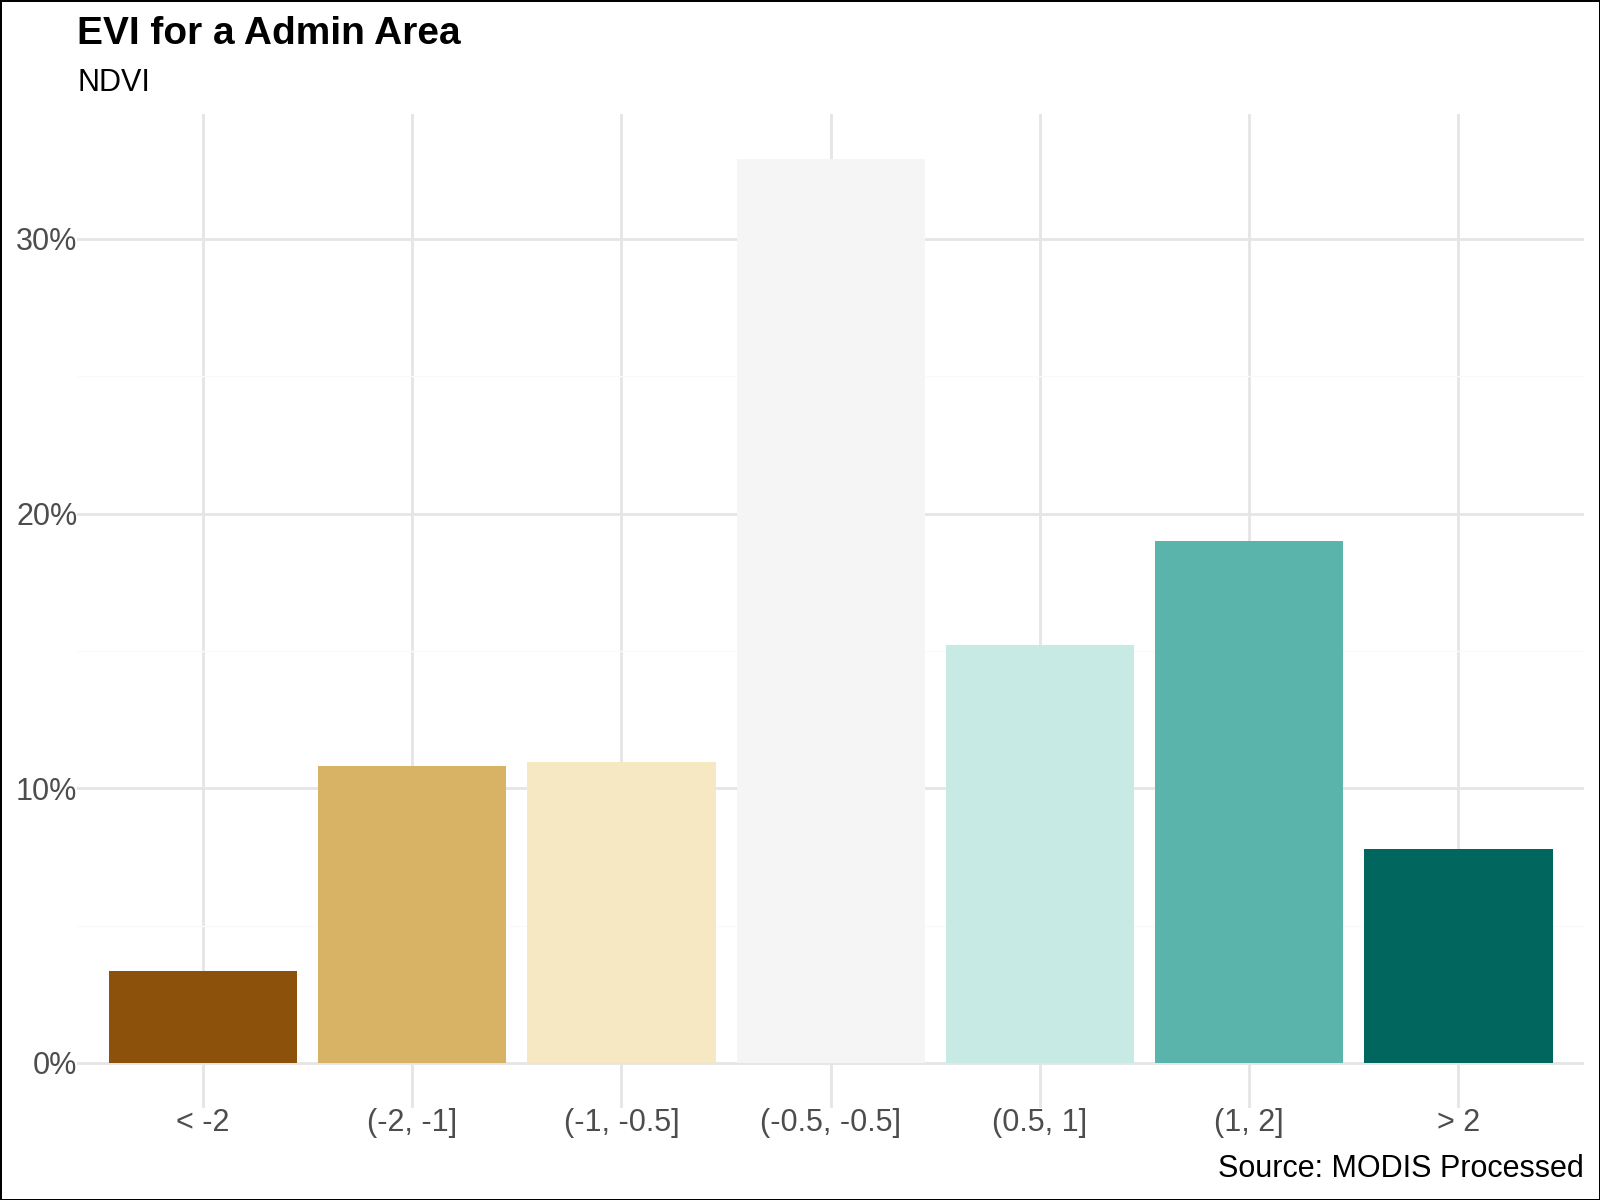

In [229]:
# fig, ax = plt.subplots()

(
ggplot(df2, aes(x="zscore_bin", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity') #  fill='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_fill_brewer(type='div', palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [247]:
df.loc[:, "zscore_bin_cat"] = pd.Categorical(df['zscore_bin'], categories=bin_labels, ordered=True)

In [249]:
df.zscore_bin_cat.value_counts()

zscore_bin_cat
< -2            5
(-2, -1]        5
(-1, -0.5]      5
(-0.5, -0.5]    5
(0.5, 1]        5
(1, 2]          5
> 2             5
Name: count, dtype: int64

In [253]:
position_fill(reverse=True)

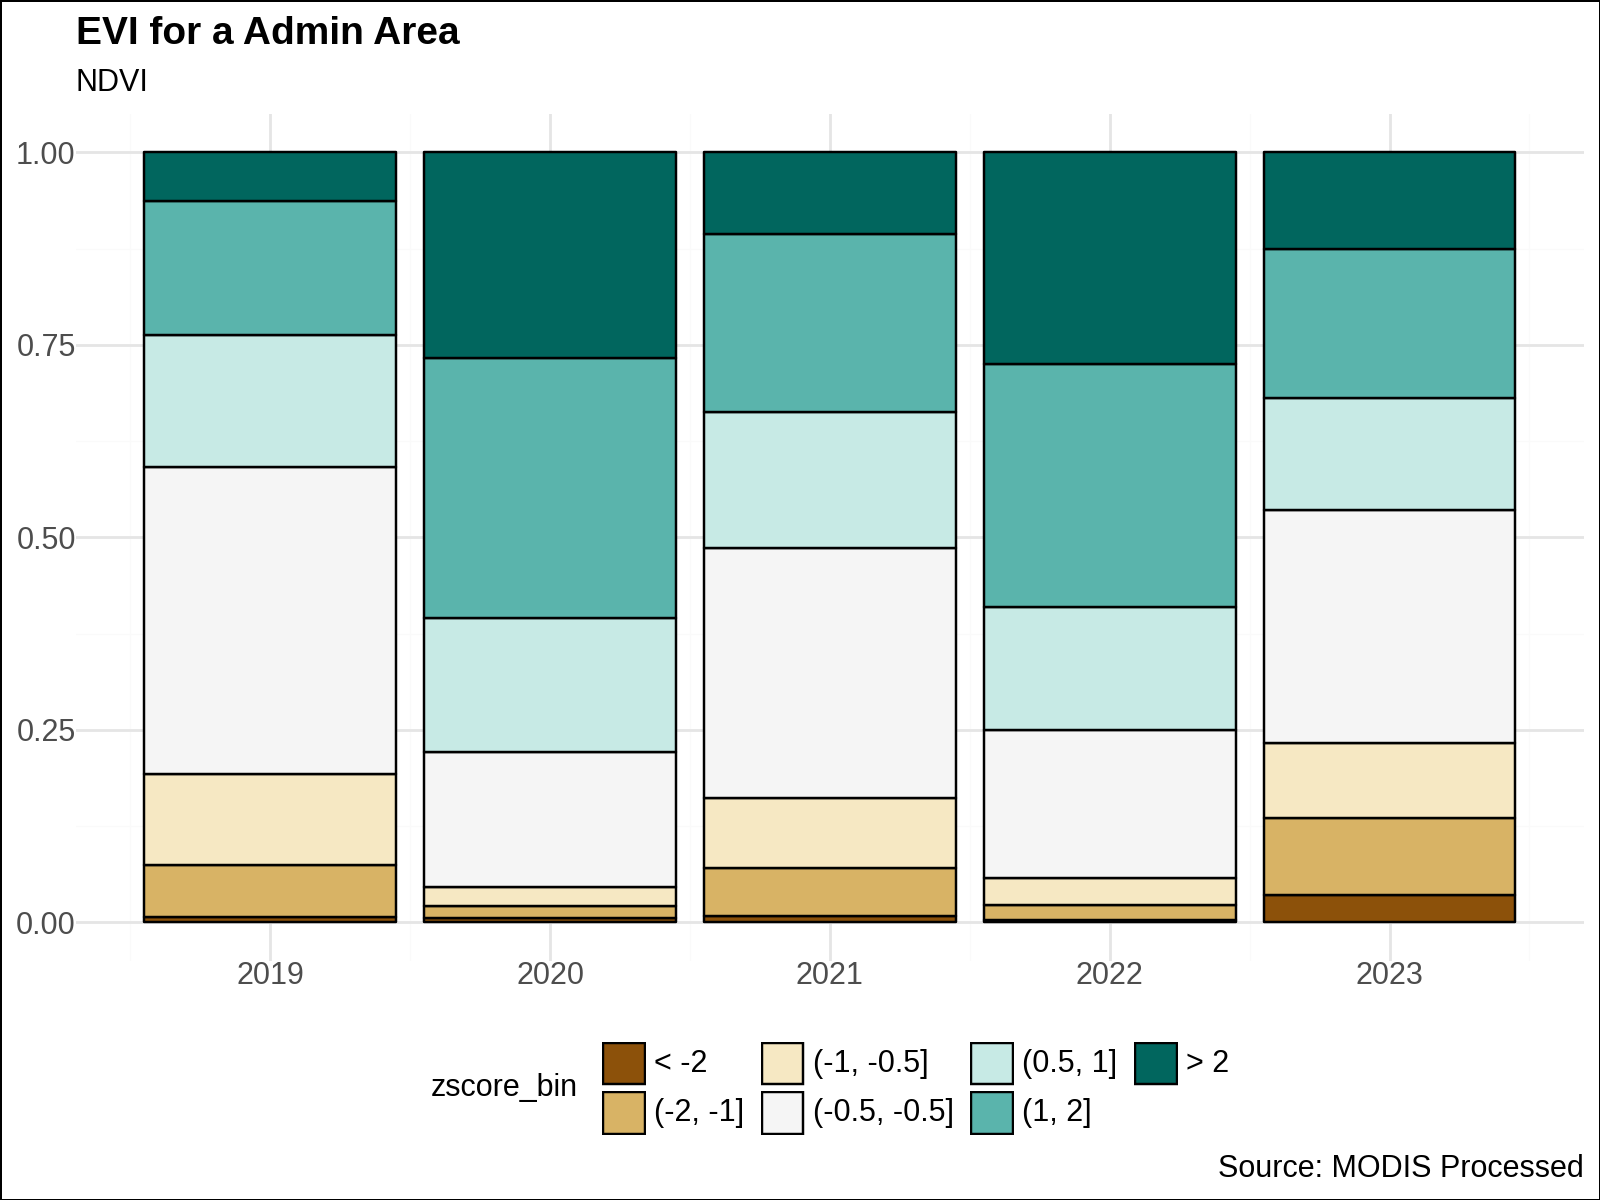

In [254]:
# fig, ax = plt.subplots()
(
ggplot(df, aes(x="year", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity', color='black', position = position_fill(reverse=True)) #  fill='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_fill_brewer(type='div', palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
)

In [265]:
charts_dir = join(expanduser('~'), 'Repos', 'niger')

In [270]:
# import plotnine
# plotnine.options.figure_size

### Evi Anomalies Chart

In [266]:
# fig, ax = plt.subplots()
p = (
ggplot(df, aes(x="year", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat='identity', color='black', width=0.5, position = position_fill(reverse=True)) #  fill='#006d2c'
    + labs(
        x="", subtitle="% of Crop Area", title="Anomalies in Agricultural Productivity (EVI)", 
        y="", caption="Source: MODIS Terra and Aqua", fill="Z-Score"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="bottom"
        )
    + scale_fill_brewer(type='div', palette="BrBG", direction=1)
    + coord_flip()
    + scale_y_continuous(labels=percent_format())

    
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)
p.save(
    filename=join(
        charts_dir, "evi-anomalies-pct.jpeg"
    ),
    dpi=300,
)

/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/jupyter-wb514197/Repos/niger/evi-anomalies-pct.jpeg


In [174]:
# bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
# bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, -0.5]', '(0.5, 1]', '(1, 2]', '> 2']

# df = pd.DataFrame(data, columns=['zscore'])
# df.loc[:, 'zscore_bin'] = pd.cut(data, bins=bins, include_lowest=True, labels=bin_labels)
# df2 = df['zscore_bin'].value_counts().sort_index()
# df2 = pd.DataFrame(df2).reset_index()
# df2.loc[:, 'pct'] = df2['count'] / df2['count'].sum()

,zscore,zscore_bin
0,0.569313,"(0.5, 1]"
1,-0.032612,"(-0.5, -0.5]"
2,0.379615,"(-0.5, -0.5]"
3,-0.538359,"(-1, -0.5]"
4,0.399906,"(-0.5, -0.5]"
...,...,...
1755367,1.553685,"(1, 2]"
1755368,0.289687,"(-0.5, -0.5]"
1755369,-0.530185,"(-1, -0.5]"
1755370,-1.447524,"(-2, -1]"


## Zonal Stats

In [398]:
a = ds_geo.rio.transform()
a

Affine(250.0, 0.0, -466208.4527382861,
       0.0, -250.00000000000006, 2618178.8511287076)

In [399]:
data_dir

'/home/jupyter-wb514197/data/niger'

In [401]:
adm1_ner_v2 = gpd.read_file(join(data_dir, 'NER_admbnda_adm1_IGNN_20230720.shp'))

In [402]:
adm1_ner_v2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [403]:
utm = 'EPSG:32632' # 'EPSG:4326' 'SR-ORG:6974' 'EPSG:23847'
# adm_df = adm0_ner.copy()
adm_df = adm1_ner_v2.copy()
adm_df = adm_df.to_crs(utm)

In [404]:
# res = []
var = 'evi'
for date in tqdm(ds_geo.time.values):
    date = pd.to_datetime(date).strftime('%Y%m%d')
    ds_sel = ds_geo.sel(time=date)
    data = ds_sel['veg_index'].values
    zs = pd.DataFrame(zonal_stats(
        adm_df, data, affine=a, stats=['median'], nodata=np.nan #  'median', 'std', 'count'
        ), index=adm_df.index
    ).rename(columns={'median': f'{var}-median_{date}'})
    adm_df = adm_df.join(zs)
    # .rename(columns={'mean':'mean_'+str(date), 'median':'median_'+str(date), 'std':'std_'+str(date), 'count':'count_'+str(date)})
    # res.append(zs)

  0%|          | 0/920 [00:00<?, ?it/s]

In [405]:
adm_df.head(2)

,ADM1_FR,ADM1_PCODE,ADM1_REF,ADM0_FR,ADM0_PCODE,date,validOn,validTo,Shape_Leng,Shape_Area,...,evi-median_20231016,evi-median_20231024,evi-median_20231101,evi-median_20231109,evi-median_20231117,evi-median_20231125,evi-median_20231203,evi-median_20231211,evi-median_20231219,evi-median_20231227
0,Zinder,NE007,None,Niger (the),NE,2023-06-21,2023-07-25,None,16.772824,12.324048,...,0.185367,0.177533,0.168433,0.163333,0.160167,0.156333,0.153200,0.148933,0.146200,0.144400
1,Dosso,NE003,None,Niger (the),NE,2023-06-21,2023-07-25,None,8.952285,2.619557,...,0.183467,0.174233,0.165567,0.158800,0.156367,0.152667,0.150267,0.146467,0.146733,0.146283


In [407]:
df_re = pd.wide_to_long(
    adm_df,
    stubnames = ['evi-median'],
    i = 'ADM1_FR', #ShapeName
    j = 'ymd',
    sep = "_"
)

In [408]:
df_re.reset_index(inplace=True)
df_re.drop(columns=['geometry'], inplace=True)
df_re.to_csv(join(data_dir, 'modis_crop_dea_niger_adm1_v2.csv'), index=False)

### Load Table

In [58]:
df_re = pd.read_csv(join(data_dir, 'modis_crop_niger_adm1.csv'))

In [409]:
df_re.head(2)

,ADM1_FR,ymd,Shape_Area,date,Shape_Leng,ADM1_PCODE,ADM0_FR,validTo,AREA_SQKM,ADM1_REF,validOn,ADM0_PCODE,evi-median
0,Zinder,20040101,12.324048,2023-06-21,16.772824,NE007,Niger (the),None,146640.856852,None,2023-07-25,NE,0.144333
1,Dosso,20040101,2.619557,2023-06-21,8.952285,NE003,Niger (the),None,31413.185964,None,2023-07-25,NE,0.147300


In [410]:
df_re.ymd = pd.to_datetime(df_re.ymd, format="%Y%m%d")
df_re.loc[:, "year"] = df_re.ymd.dt.year

In [411]:
df = df_re.copy()
# df.set_index('ymd', inplace=True)

In [412]:
df.head()

,ADM1_FR,ymd,Shape_Area,date,Shape_Leng,ADM1_PCODE,ADM0_FR,validTo,AREA_SQKM,ADM1_REF,validOn,ADM0_PCODE,evi-median,year
0,Zinder,2004-01-01,12.324048,2023-06-21,16.772824,NE007,Niger (the),None,146640.856852,None,2023-07-25,NE,0.144333,2004
1,Dosso,2004-01-01,2.619557,2023-06-21,8.952285,NE003,Niger (the),None,31413.185964,None,2023-07-25,NE,0.147300,2004
2,Tillabéri,2004-01-01,7.562910,2023-06-21,17.175163,NE006,Niger (the),None,90311.752888,Tillaberi,2023-07-25,NE,0.135600,2004
3,Tahoua,2004-01-01,9.052035,2023-06-21,14.184350,NE005,Niger (the),None,107312.379816,None,2023-07-25,NE,0.134433,2004
4,Agadez,2004-01-01,53.541759,2023-06-21,32.885549,NE001,Niger (the),None,621895.429177,None,2023-07-25,NE,0.096717,2004


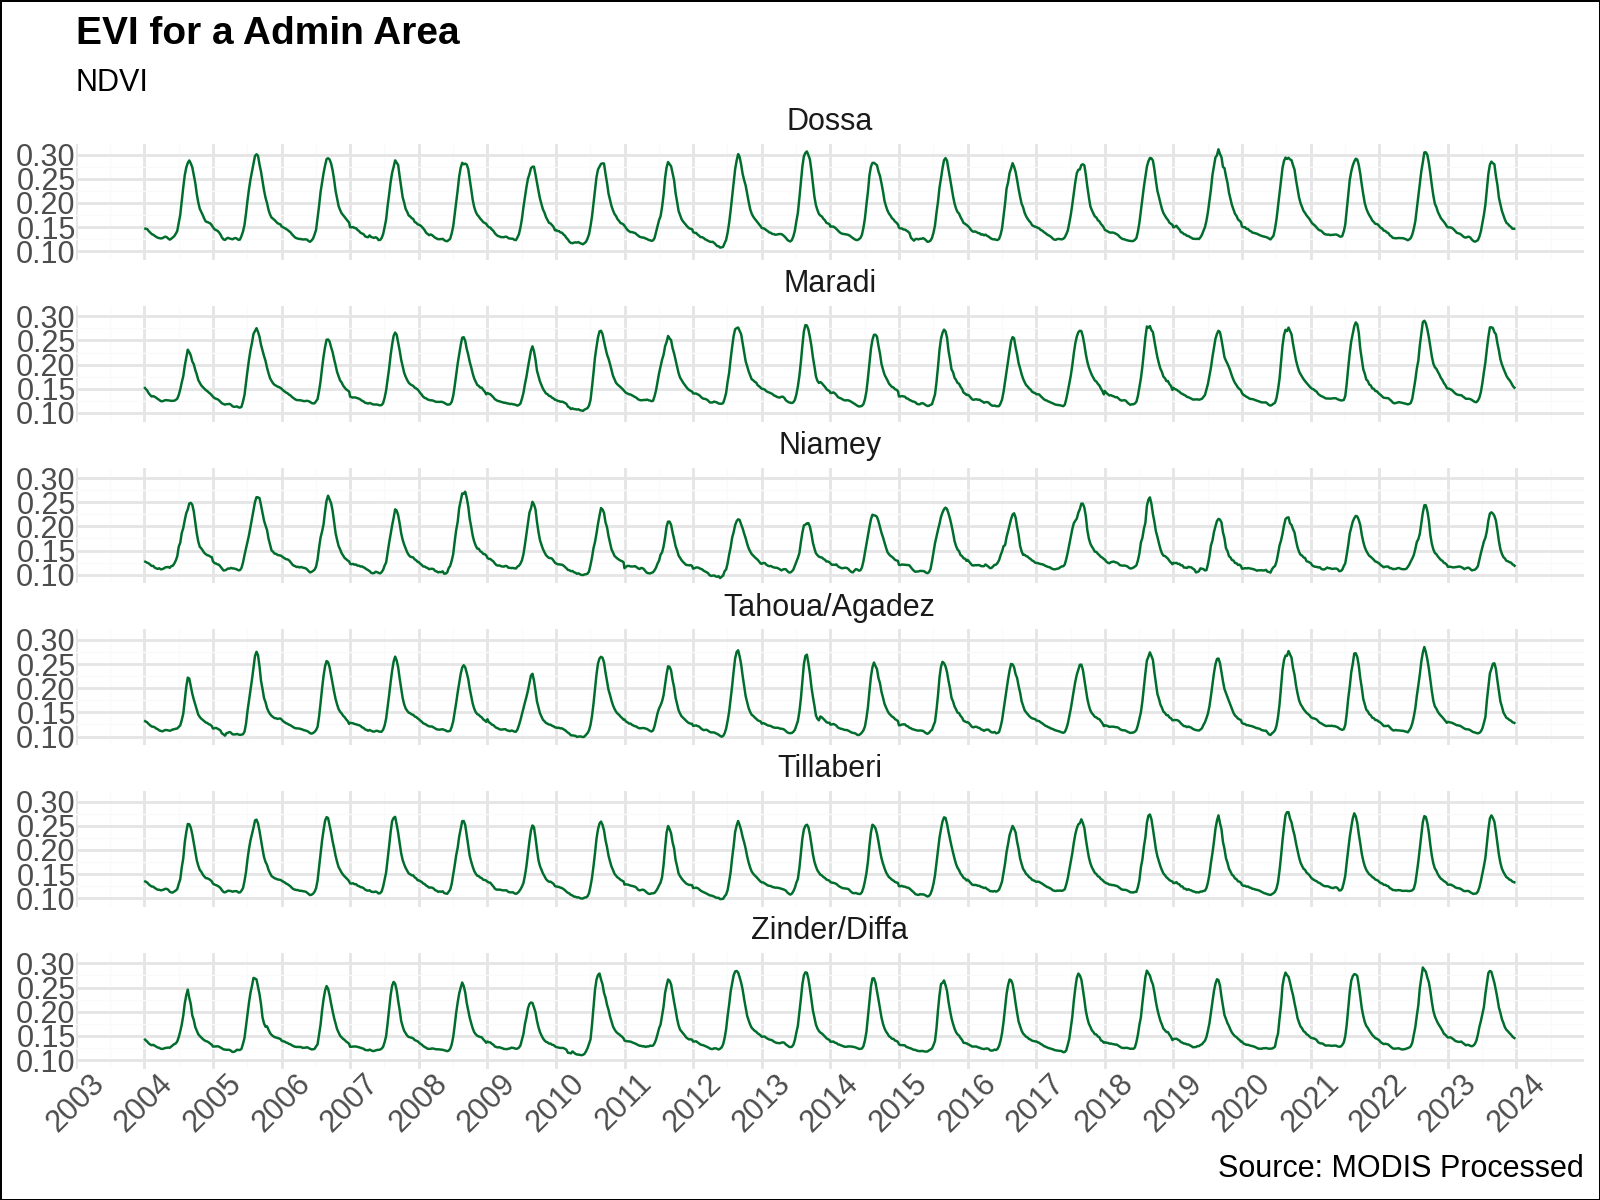

In [288]:
# fig, ax = plt.subplots()
(
ggplot(df, aes(x="ymd", y="evi-median", group="shapeName"))
    + geom_line(alpha=1, color='#006d2c') #
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + facet_wrap('shapeName', ncol=1)
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [413]:
dates = df.ymd.unique()
dates_copy = []
leap_years = [2004, 2008, 2012, 2016, 2020, 2024]

In [414]:
for date in dates:
    date_copy = date
    if (date.year in leap_years) and (date.month > 2):
        date_copy = date + pd.DateOffset(days=1)
    dates_copy.append(date_copy)

In [415]:
dates_df = pd.DataFrame({'ymd': dates, 'ymd2': dates_copy})

In [416]:
df = df.merge(dates_df, on='ymd', how='left')

In [417]:
df.loc[:, "md"] = df.ymd2.dt.strftime("%m-%d")

In [418]:
# df.head(10)

## Reference ZS

In [420]:
start_reference = "2004-01-01"
end_reference = "2019-01-01"
df_ref = df.loc[(df.ymd >= start_reference) & (df.ymd < end_reference)].copy()

df_ref = df_ref.groupby(["ADM1_FR", "md"])[
    ["evi-median"]
].mean()
df_ref.reset_index(inplace=True)
df_ref.rename(
    columns={
        "evi-median": "evi-median_ref"
    },
    inplace=True,
)

In [421]:
df_ref.tail(2)

,ADM1_FR,md,evi-median_ref
366,Zinder,12-19,0.141113
367,Zinder,12-27,0.138657


In [422]:
df_filt = df.loc[(df.ymd >= "2023-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["ADM1_FR", "md"], how="left", validate="m:1")

In [423]:
# calculate z score 
# df_filt.loc[:, "zscore"] = zscore(df_filt["evi-median"], nan_policy='omit')

In [424]:
df_filt.head(1)

,ADM1_FR,ymd,Shape_Area,date,Shape_Leng,ADM1_PCODE,ADM0_FR,validTo,AREA_SQKM,ADM1_REF,validOn,ADM0_PCODE,evi-median,year,ymd2,md,evi-median_ref
0,Zinder,2023-01-01,12.324048,2023-06-21,16.772824,NE007,Niger (the),None,146640.856852,None,2023-07-25,NE,0.146883,2023,2023-01-01,01-01,0.136578


In [303]:
df_filt.loc[:, "evi_pct_ch"] = df_filt.apply(
    lambda x: (x['evi-median'] - x['evi-median_ref']) / (x['evi-median_ref']), axis=1
)

In [324]:
df_filt = df.loc[(df.ymd >= "2022-01-01") & (df.ymd < "2023-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["shapeName", "md"], how="left", validate="m:1")

In [425]:
df_filt = df.loc[(df.ymd >= "2022-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["ADM1_FR", "md"], how="left", validate="m:1")
df_filt.loc[:, "ymd3"] = "2023-"+df_filt.md
df_filt.ymd3 = pd.to_datetime(df_filt.ymd3, format="%Y-%m-%d")

In [426]:
df_filt.year.unique()

array([2022, 2023], dtype=int32)

### Admin 1 Median Chart

In [429]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
p2 = (
ggplot(df_filt, aes(x="ymd3", y="evi-median", group="factor(year)", color="factor(year)"))
    + geom_line(alpha=1, size=1.4) # color='#006d2c'
    + geom_line(df_filt.loc[df_filt.year==2023], 
                aes(x="ymd3", y="evi-median_ref", group="ADM1_FR"), alpha=0.8, size=1.4, color='gray', linetype='dotted'
                ) #
    + labs(
        x="", subtitle="EVI", title="Median EVI vs. Historical Average", 
        y="", caption="Source: MODIS Processed", color="Year"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 10), # 10, 16
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="right",
        )
    # + theme(figure_size=(10, 16))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + facet_wrap('ADM1_FR', ncol=1)
    + scale_color_brewer(type='qual', palette="Set1")
    # + scale_color_brewer(type='div', palette="PiYG", direction=1)
    # + scale_color_brewer(type='seq', palette="Greens", direction=1)
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)
p2.save(
    filename=join(
        charts_dir, "evi-median-adm1-v2.jpeg"
    ),
    dpi=300,
)

/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 10 in image.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/jupyter-wb514197/Repos/niger/evi-median-adm1-v2.jpeg


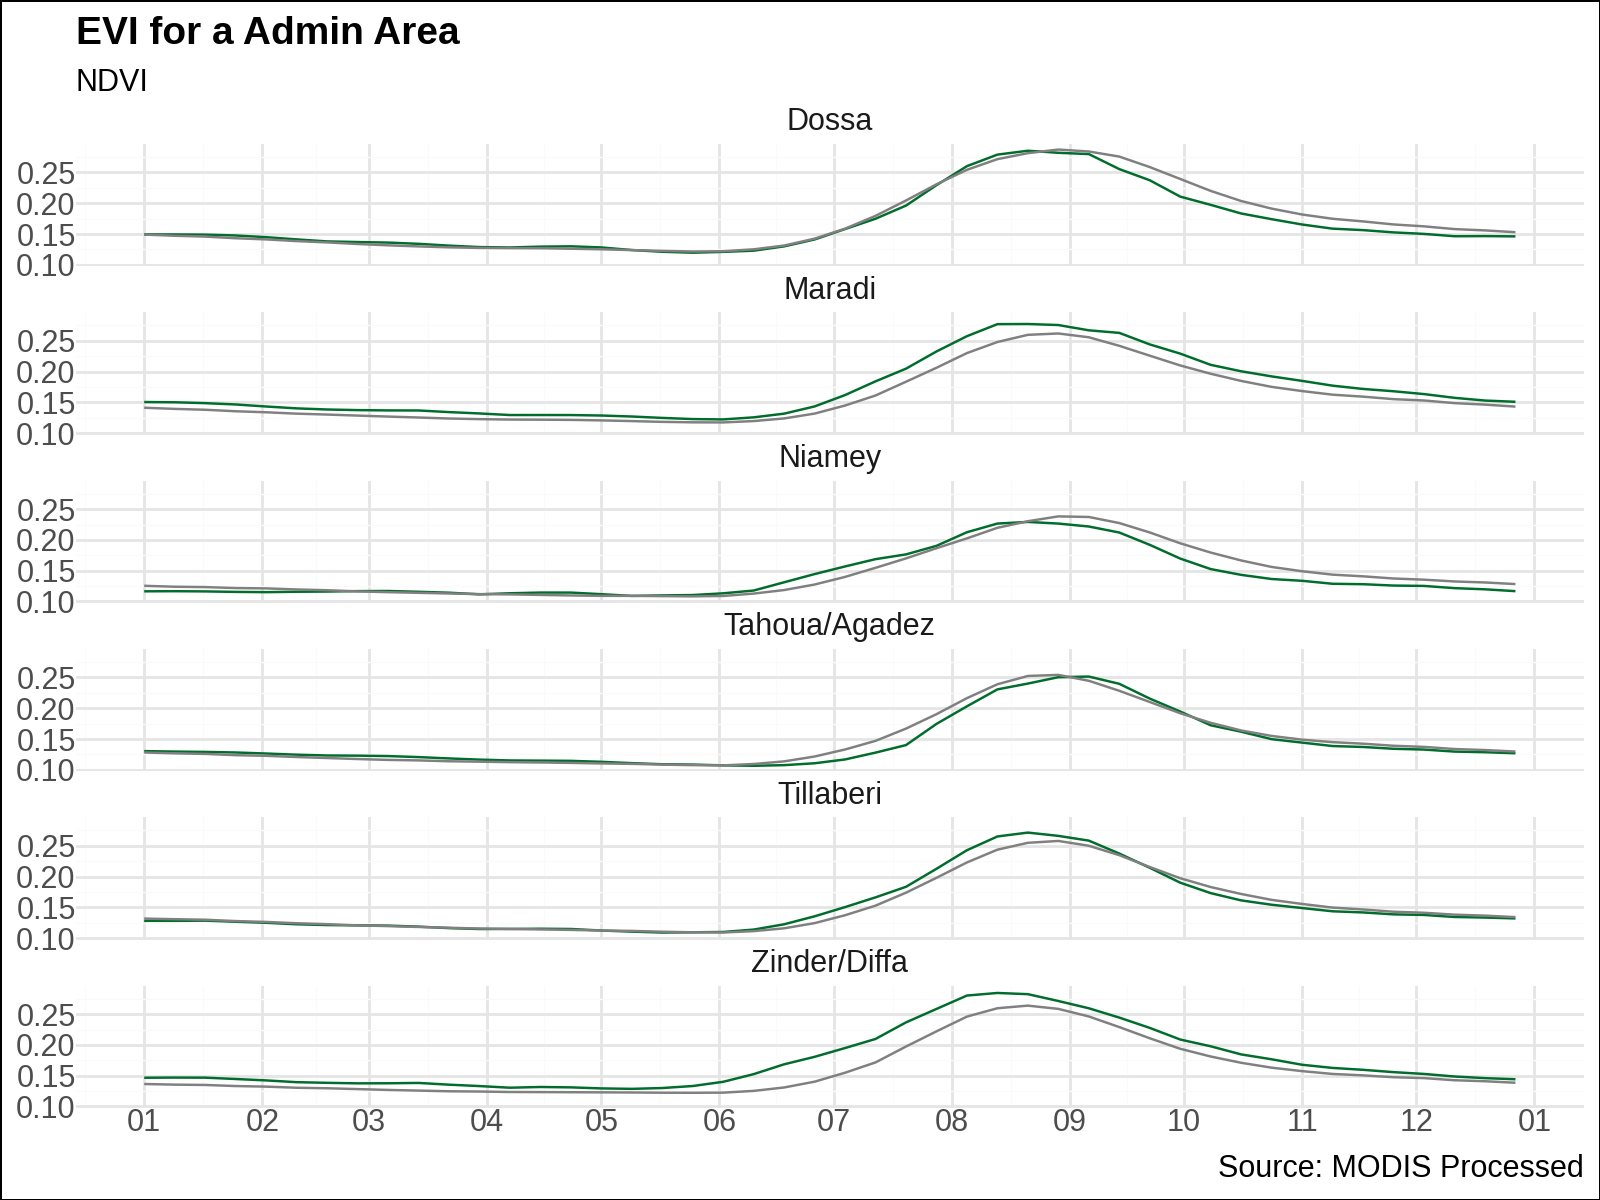

In [317]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
(
ggplot(df_filt, aes(x="ymd2	", y="evi-median", group="shapeName"))
    + geom_line(alpha=1, color='#006d2c') #
    + geom_line(aes(x="ymd2	", y="evi-median_ref", group="shapeName"), alpha=1, color='gray') #
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + facet_wrap('shapeName', ncol=1)
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [74]:
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [75]:
# font_names = [
#     "LiberationSansNarrow",
#     "Quicksand",
#     "UbuntuMono",
#     "NimbusRoman",
#     "DejaVuSansCondensed",
#     "Trebuchet MS",
#     "NimbusSans",
#     "Ubuntu",
#     "NimbusMonoPS",
#     "DejaVuSans"
# ]
font = "Liberation Sans"

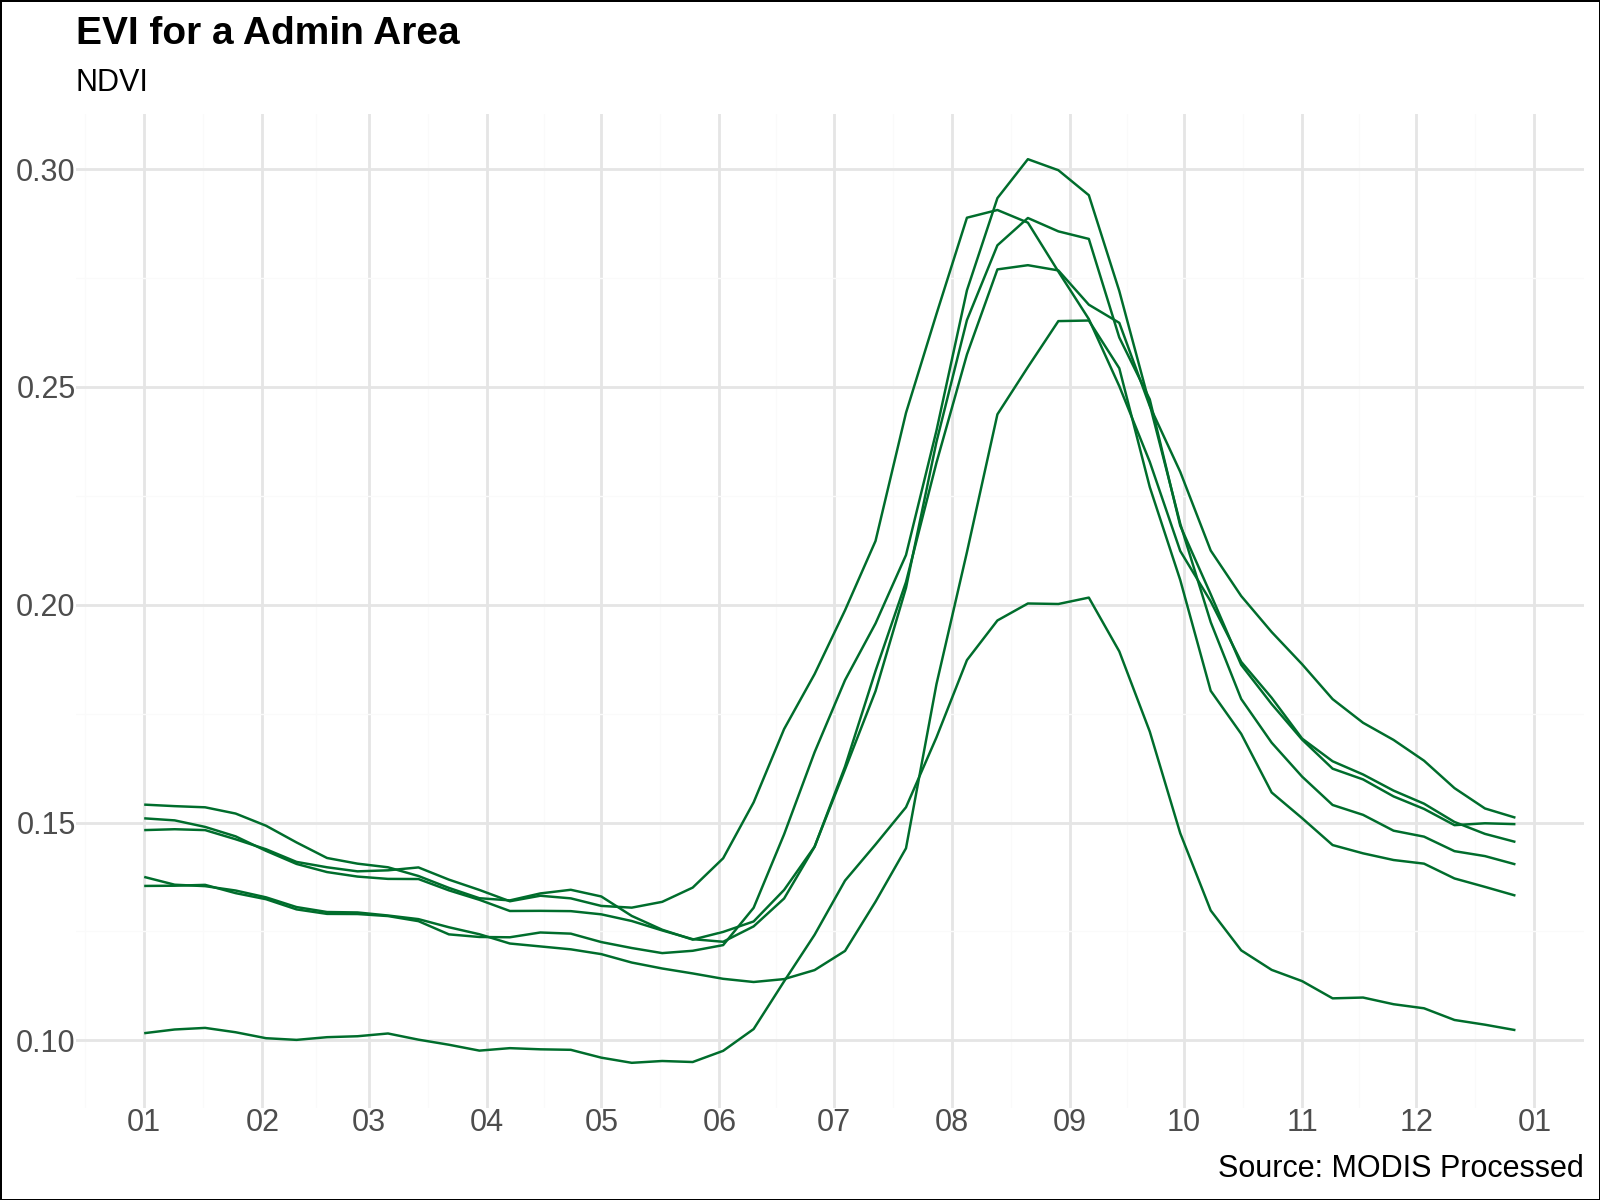

In [77]:
# fig, ax = plt.subplots()
(
ggplot(df_filt, aes(x="ymd2	", y="evi-median", group="shapeName"))
    + geom_line(alpha=1, color='#006d2c') #
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

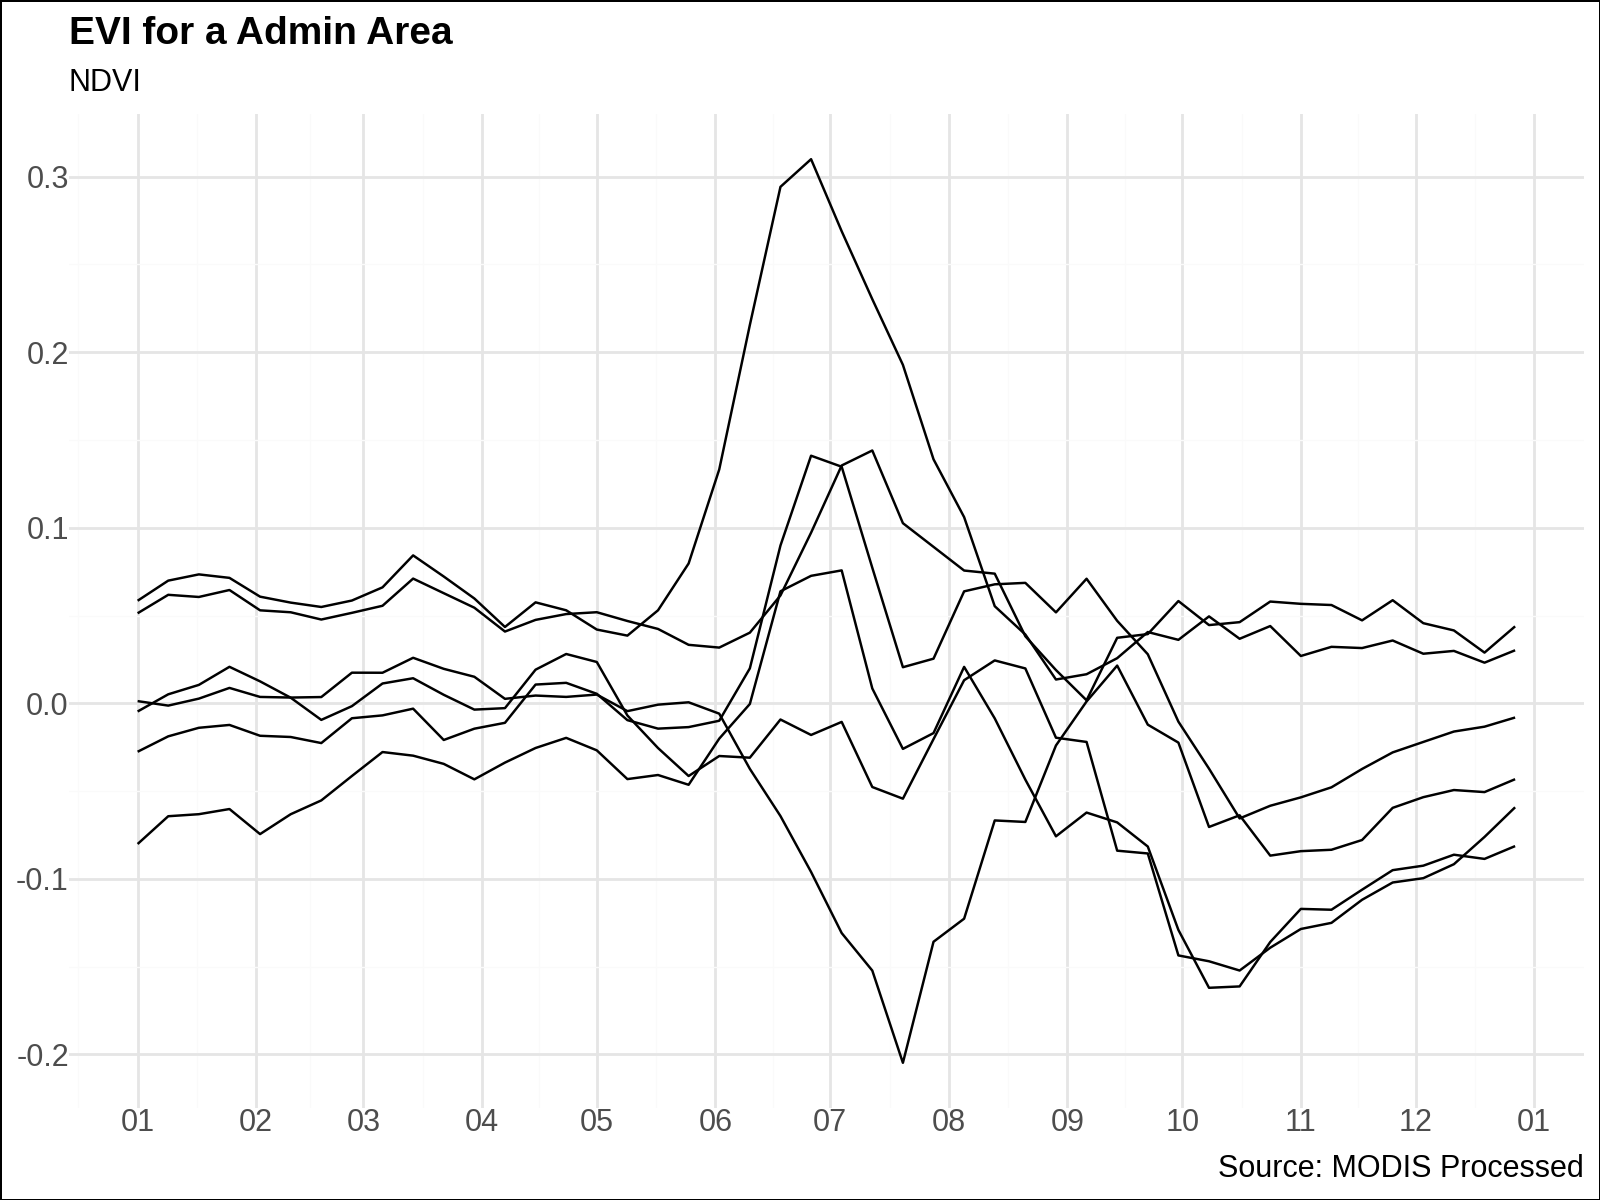

In [70]:
# fig, ax = plt.subplots()
(
ggplot(df_filt, aes(x="ymd2	", y="evi_pct_ch", group="shapeName"))
    + geom_line(alpha=1) # color='#006d2c'
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

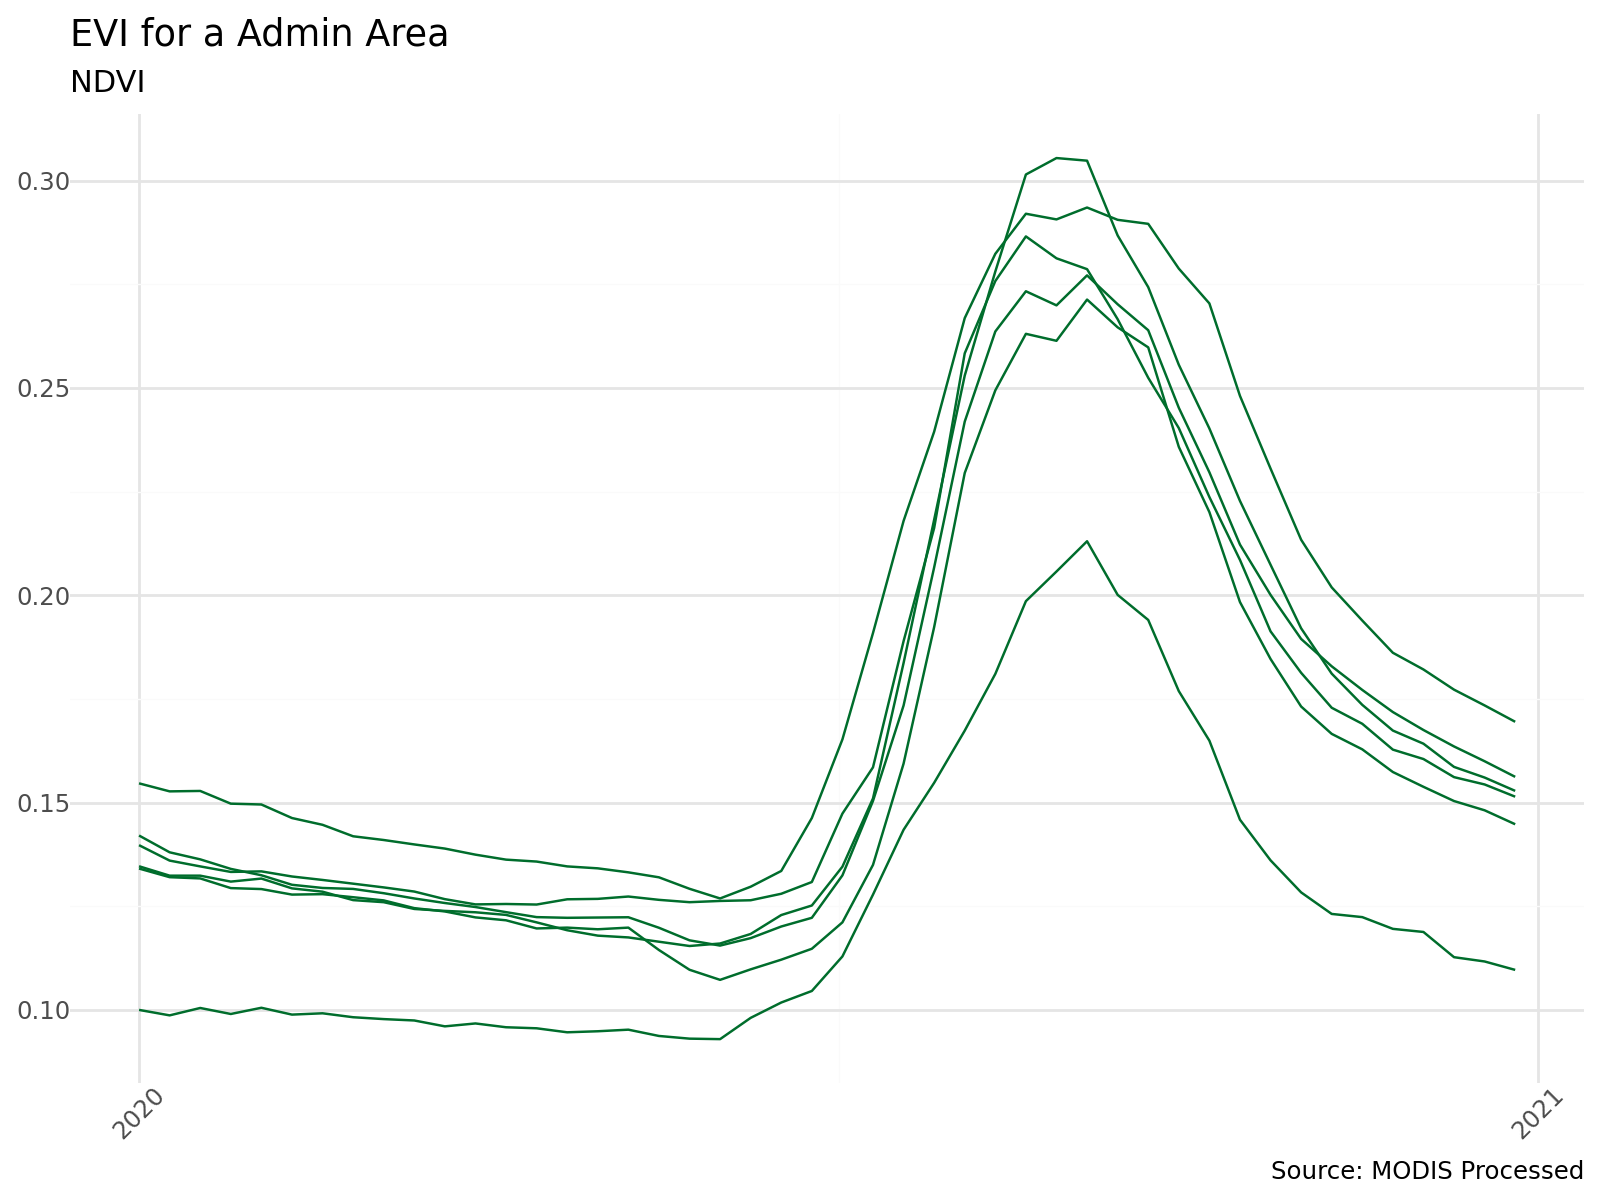

In [31]:
(
ggplot(df_re, aes(x="ymd", y="evi-median", group="shapeName"))
    + geom_line(alpha=1, color='#006d2c')
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        figure_size=(8, 6),
        # text=element_text(family="Roboto", size=11),
        # plot_title=element_text(family="Roboto", size=14, weight="bold"),
        axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

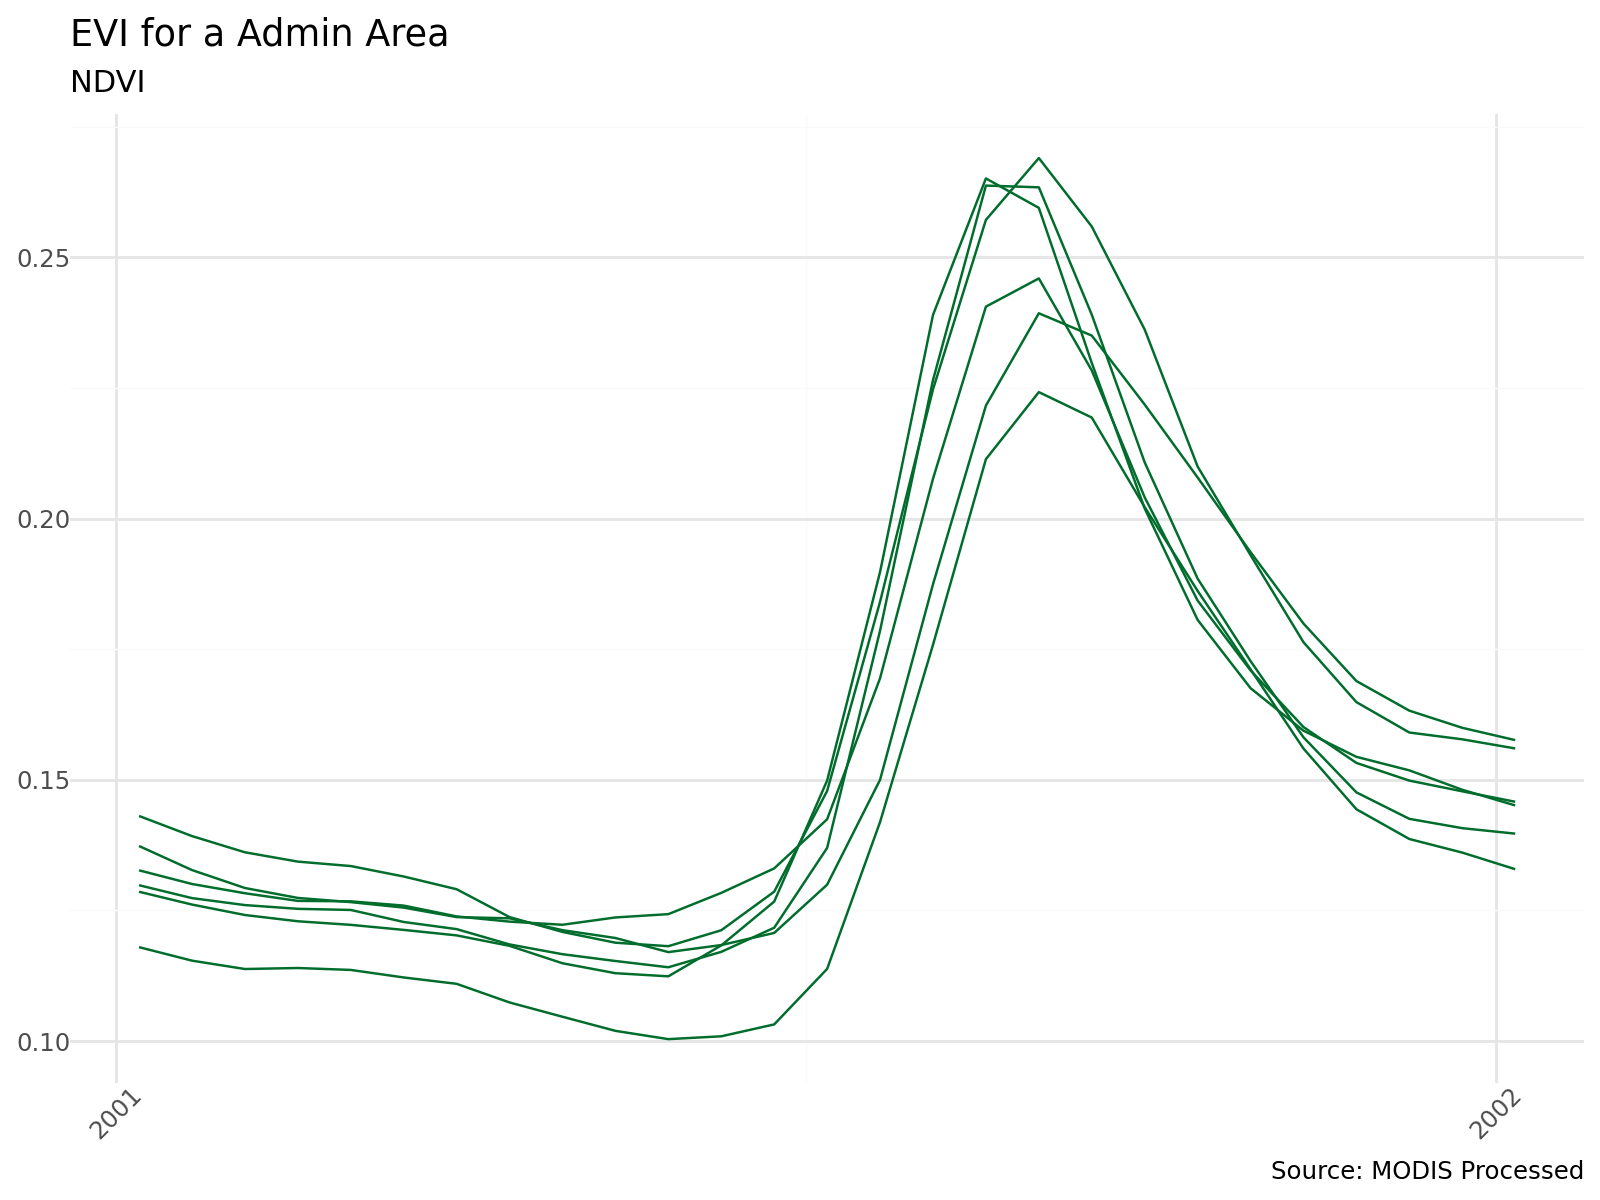

In [41]:
(
ggplot(df_re, aes(x="ymd", y="evi-median", group="shapeName"))
    + geom_line(alpha=1, color='#006d2c')
    + labs(
        x="", subtitle="NDVI", title="EVI for a Admin Area", y="", caption="Source: MODIS Processed"
    )
    + theme_minimal() 
    + theme(
        figure_size=(8, 6),
        # text=element_text(family="Roboto", size=11),
        # plot_title=element_text(family="Roboto", size=14, weight="bold"),
        axis_text_x=element_text(rotation=45),
        legend_position="none"
        )
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)